# Notebook 35: Single HR panel for one mass and all periods

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 35

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [4]:

FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [6]:
Z_SUN = 0.017

In [7]:
from astropy.cosmology import WMAP9 as cosmo
th = cosmo.age(0).to(u.yr).value

### Utilities

In [8]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [9]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [10]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [11]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [12]:
def mesareader_operator(expression, object_to_call='h'):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'{object_to_call}.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}{object_to_call}.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [13]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

### Winds

In [14]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/Z_SUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [15]:
vink2001_w = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## HR diagram

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [20]:
def hr_diagram_tracks(
    model_dicts,
    model_labels,
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    return ax, handles

In [21]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

In [22]:
def old_e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [23]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [24]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\Gamma_\\mathrm{e}$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax, handles

### Final properties

In [25]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [26]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

In [27]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1e5)
        w = 10.**log_w
    return w

def get_g_switch(l, m, t, z, x, scheme):
    z_div_zsun = z/Z_SUN
    if scheme == 'vink':
        g_switch = 0.243 * z_div_zsun**-0.541
    elif scheme == 'krticka':
        g_switch = 0.585 * z_div_zsun**-0.016
    elif scheme == 'bjorklund':
        g_switch = 0.838 * z_div_zsun**-0.099
    elif scheme == 'bjorklund+krticka':
        k24_w = krticka2024_w(l, t, z)
        b23_w = bjorklund2023_w(l, m, t, z, x)
        if k24_w <= b23_w:
            g_switch = 0.585 * z_div_zsun**-0.016
        else:
            g_switch = 0.838 * z_div_zsun**-0.099
    return g_switch

def vink2011_winds(l, m, t, z, x, g_switch, m_switch):
    g_e = edd_gamma(x, l, m)
    v01_w = vink2001_w(l, t, m, z)
    
    if g_e < g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w
        

class Winds:
    
    def __init__(self, ms_winds):
        self.ms_winds = ms_winds
        self.g_switch = None
        self.m_switch = 10
        self.vms_switch = False
        
    def winds(self, l, m, teff, z, x, ms_winds):
        x0 = 0.6
        dx = 0.3
        
        #MS or WR winds
        if x > x0:
            he_poor_a = 1
        elif x > x0-dx:
            he_poor_a = (x - (x0-dx)) / dx
        else:
            he_poor_a = 0
        
            
        vink2001_winds = vink2001_w(l, teff, m, z)
        bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
        krticka2024_winds = krticka2024_w(l, teff, z)
        vink2017_winds = vink2017_w(l, z)
        sander2023_winds = sander2023_w(l, teff, z)
        
        if ms_winds == 'vink':
            ms_w = vink2001_winds
        elif ms_winds == 'bjorklund':
            ms_w = bjorklund2023_winds
        elif ms_winds == 'krticka':
            ms_w = krticka2024_winds
        elif ms_winds == 'bjorklund+krticka':
            ms_w = min(bjorklund2023_winds, krticka2024_winds)
        else:
            raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
        
        if self.g_switch is None:
            g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
        else:
            g_switch = self.g_switch
        g_e = edd_gamma(x, l, m)
        
        if (g_e >= g_switch) and (self.vms_switch is False):
            self.vms_switch = True
            self.m_switch = m
            self.g_switch = g_switch
            
        vms_w = vink2011_winds(l, m, teff, z, x, g_switch, self.m_switch)
        
        if g_e > g_switch:
            ms_w = vms_w        
        
        w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
        return w
    
    
def winds(l, m, teff, z, x, ms_winds='vink'):
    x0 = 0.6
    dx = 0.3
       
    #MS or WR winds
    if x > x0:
        he_poor_a = 1
    elif x > x0-dx:
        he_poor_a = (x - (x0-dx)) / dx
    else:
        he_poor_a = 0
    
        
    vink2001_winds = vink2001_w(l, teff, m, z)
    bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
    krticka2024_winds = krticka2024_w(l, teff, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, teff, z)
    
    if ms_winds == 'vink':
        ms_w = vink2001_winds
    elif ms_winds == 'bjorklund':
        ms_w = bjorklund2023_winds
    elif ms_winds == 'krticka':
        ms_w = krticka2024_winds
    elif ms_winds == 'bjorklund+krticka':
        ms_w = min(bjorklund2023_winds, krticka2024_winds)
    else:
        raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
    
    g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
    
    
    w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
    return w
    

# Analysis

In [28]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_01zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_02zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_04zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_06zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_08zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_10zsun = model_dicts

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZs

In [29]:
(model_dicts[-1]['300.0']['3.00']/'LOGS').is_dir()

True

IndexError: list index out of range

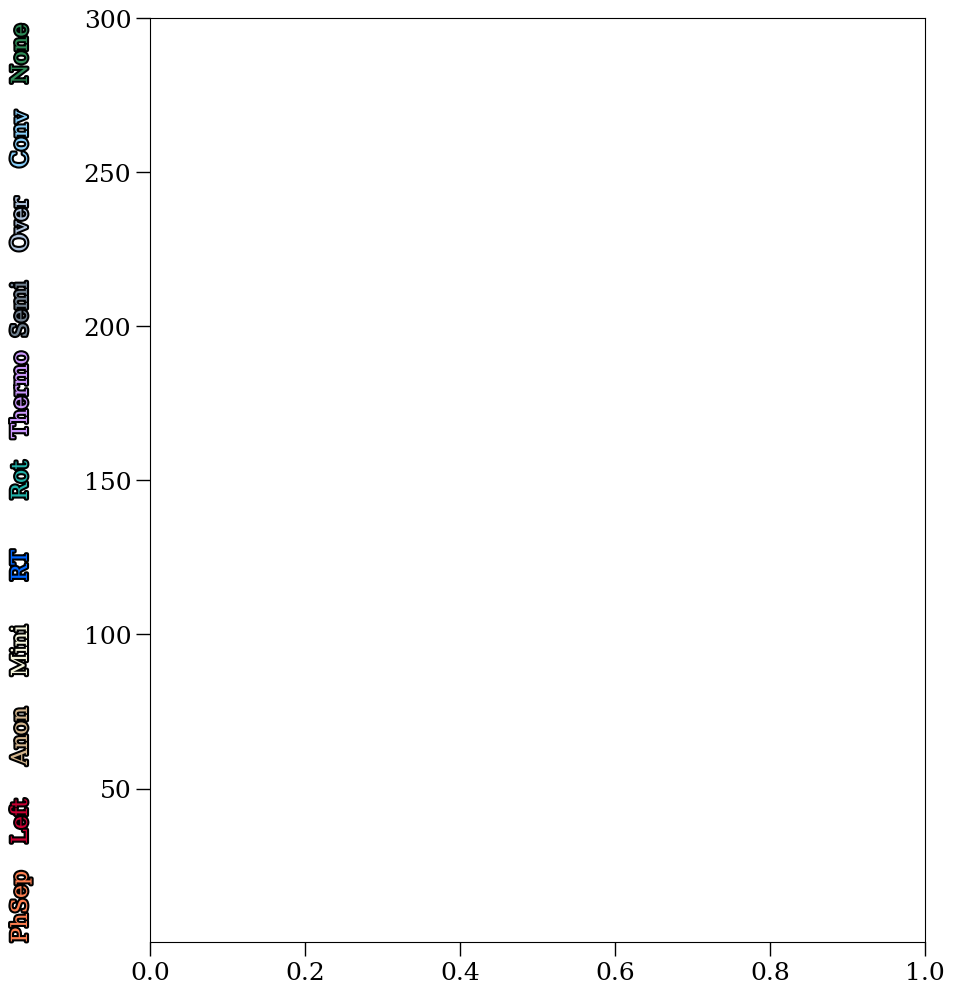

In [30]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


In [ ]:
for x in y

2332.0


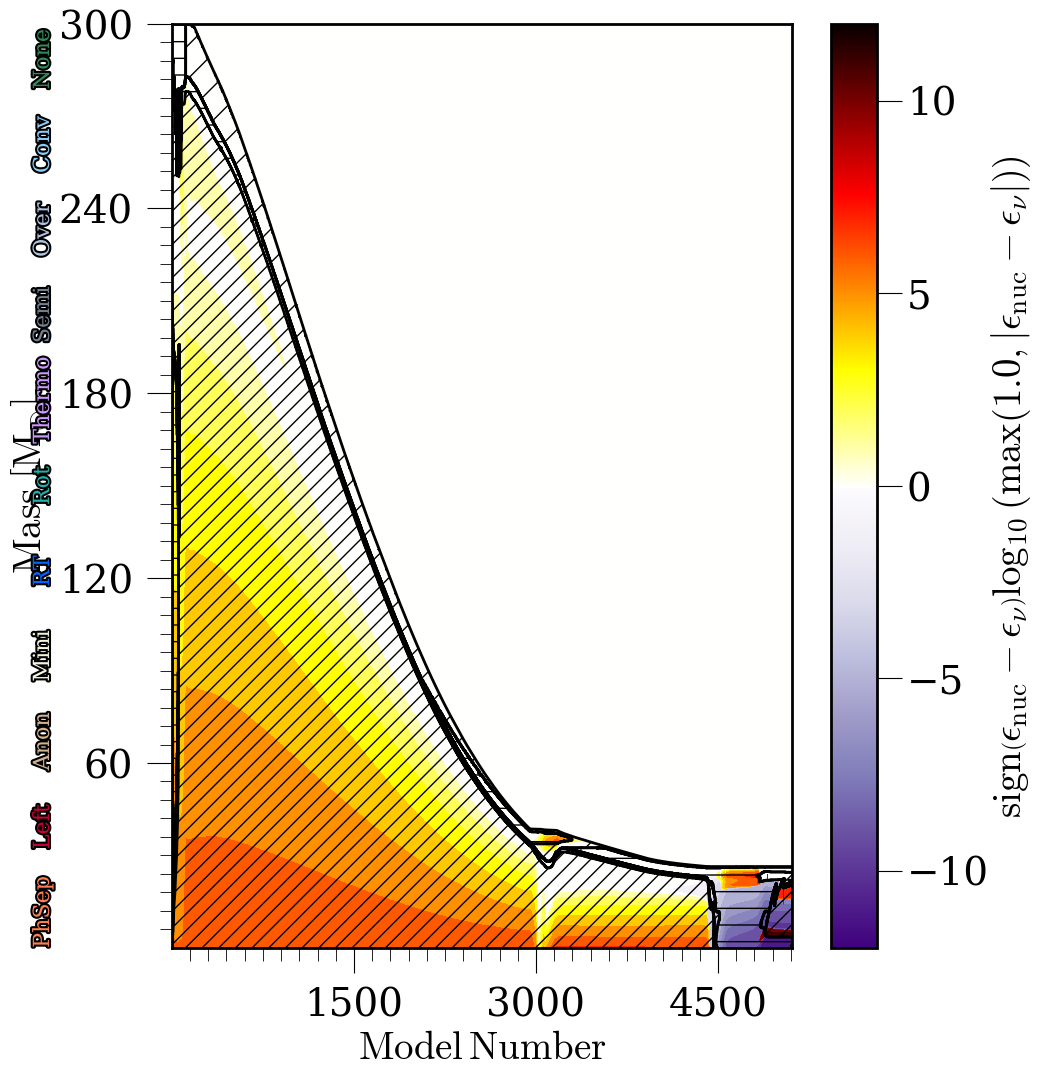

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


fig, ax = plt.subplots(figsize=(10,6))

ax = plot_profiles(ax, model_dicts_02zsun, -1, '300.0', '3.00', 'mass', 'pgas_div_ptotal', (0, -1, 10))
#ax.set_yscale('log')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)

2332.0


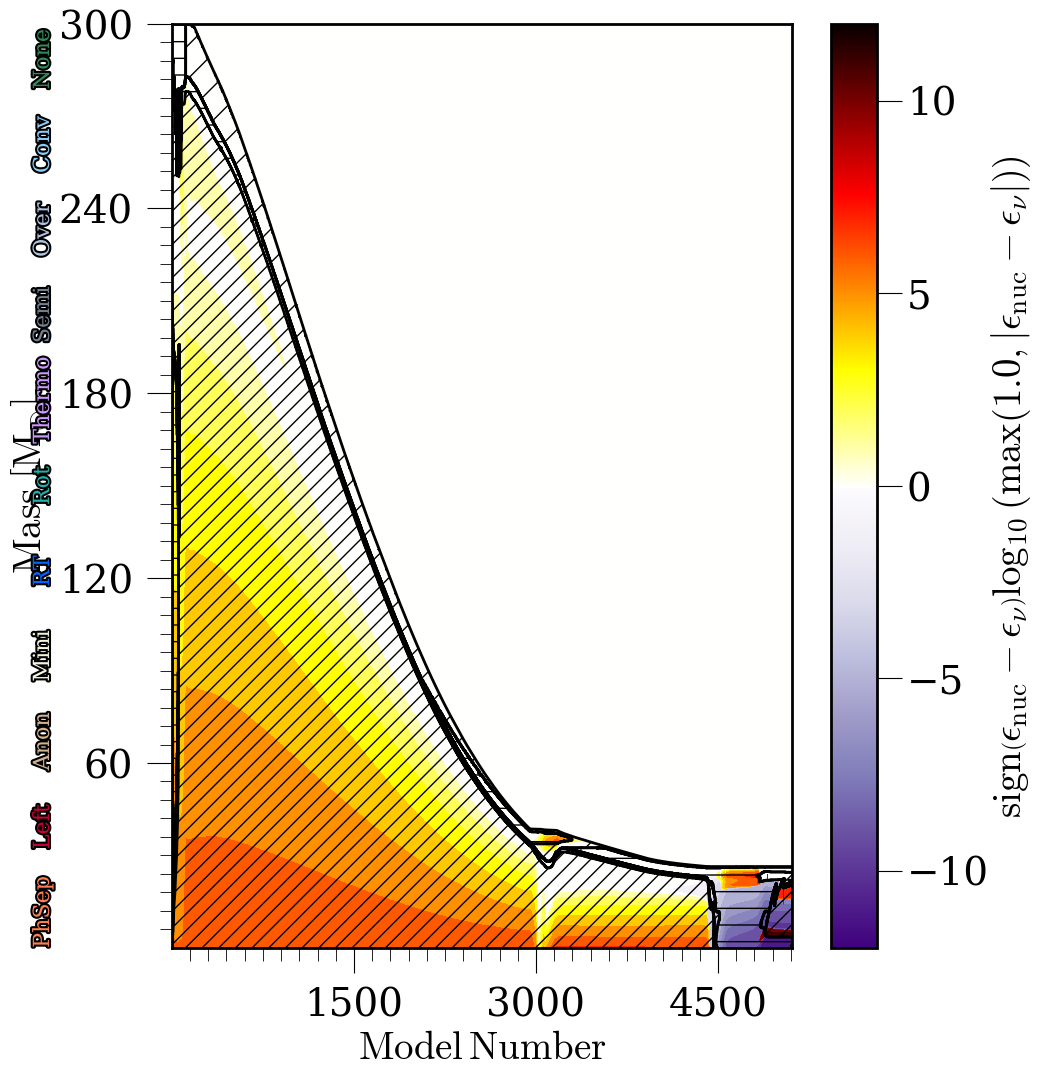

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2332.0


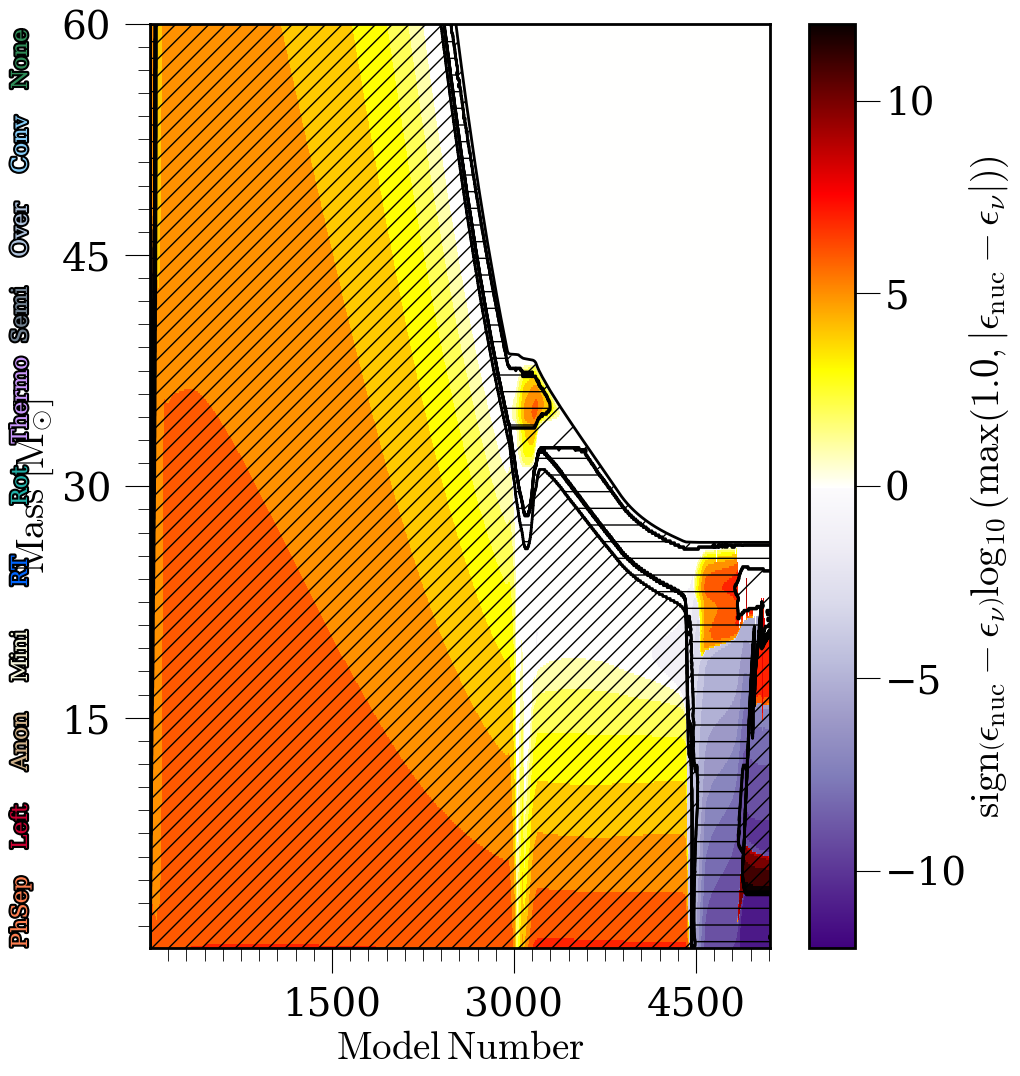

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2332.0


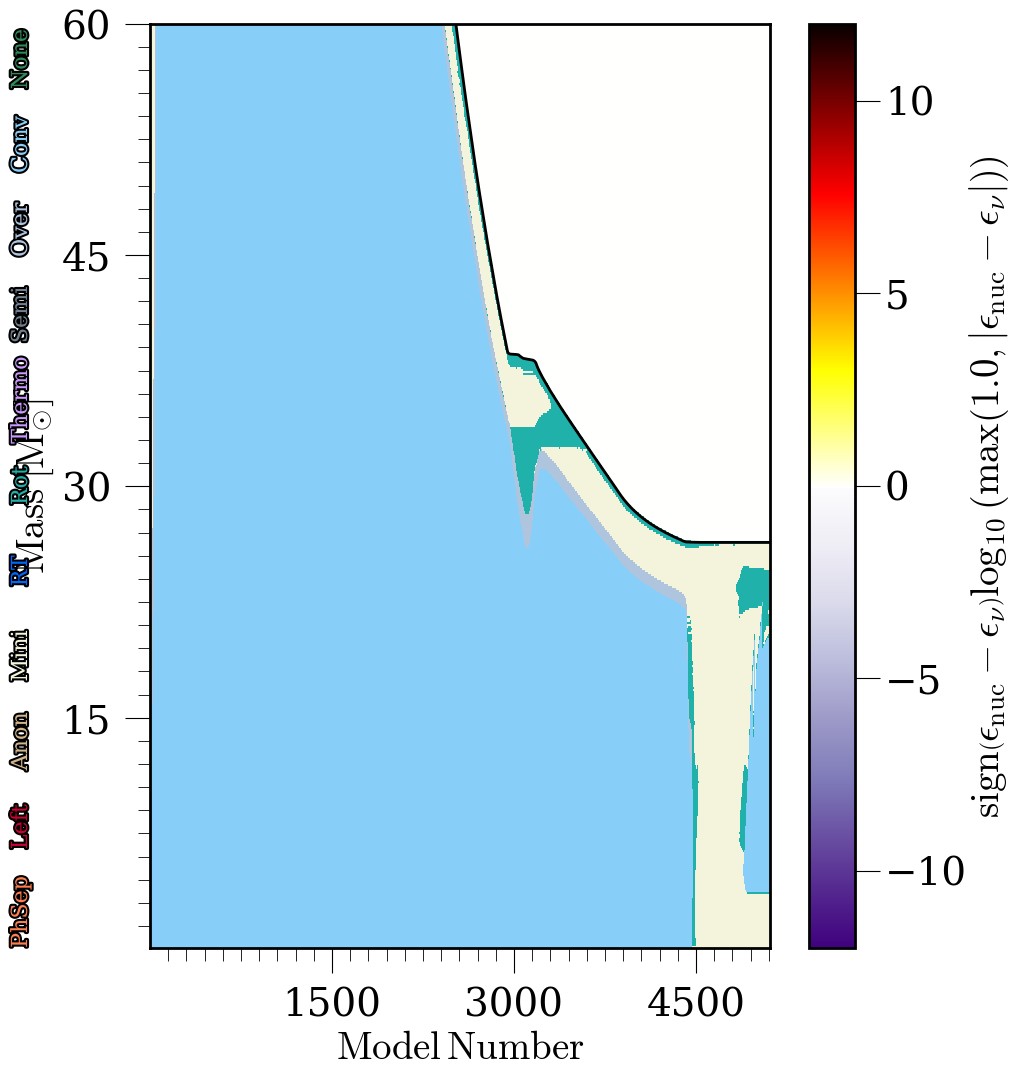

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


2465.0


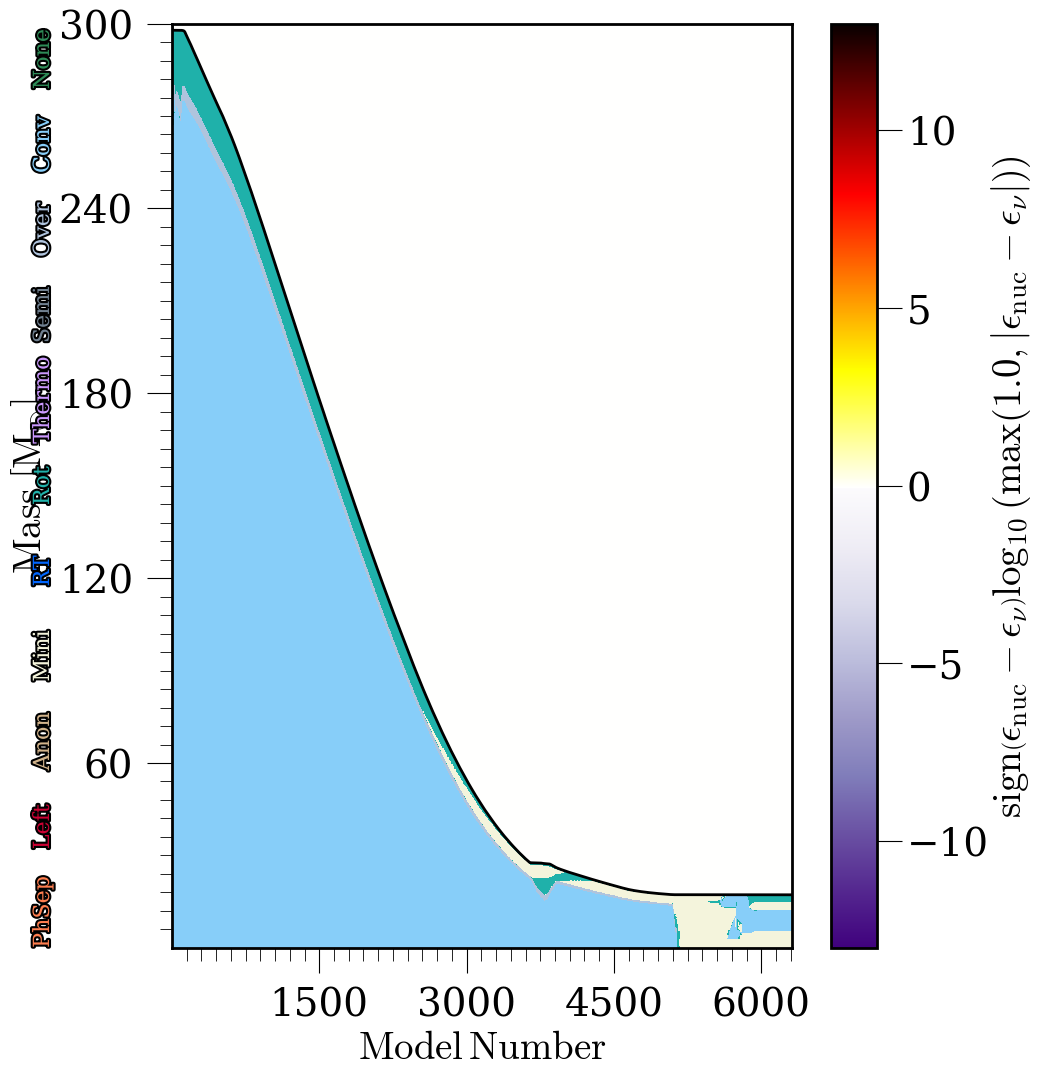

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_04zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


2465.0


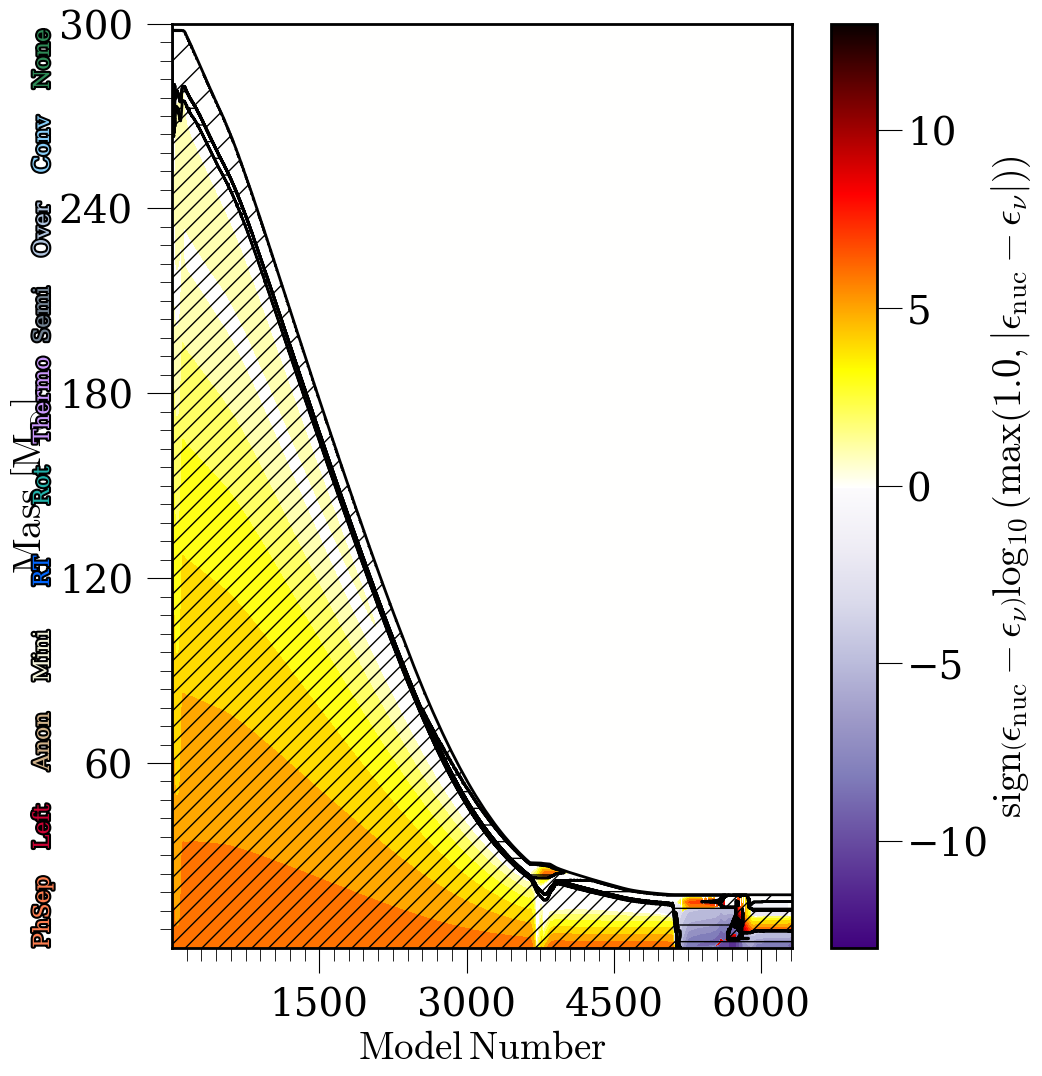

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_04zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2465.0


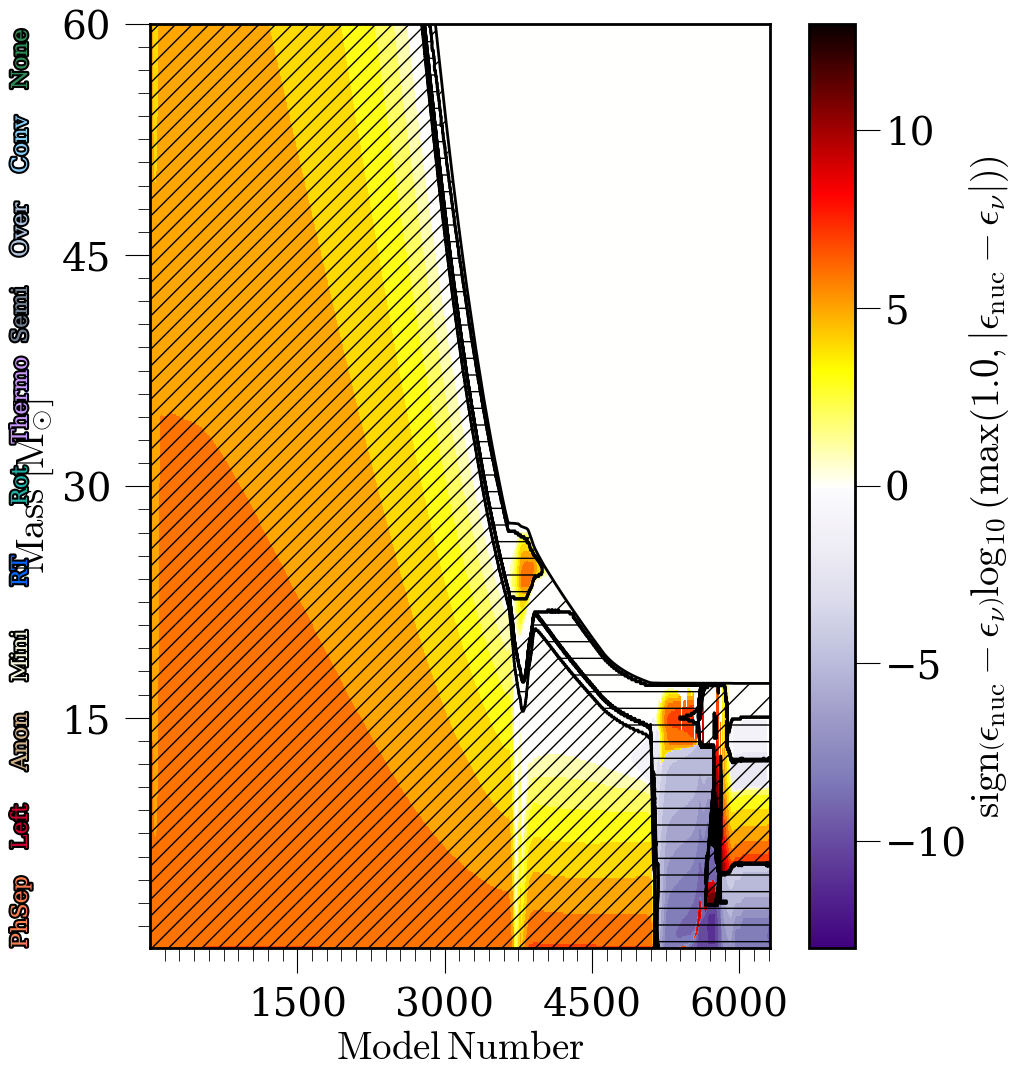

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_04zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2465.0


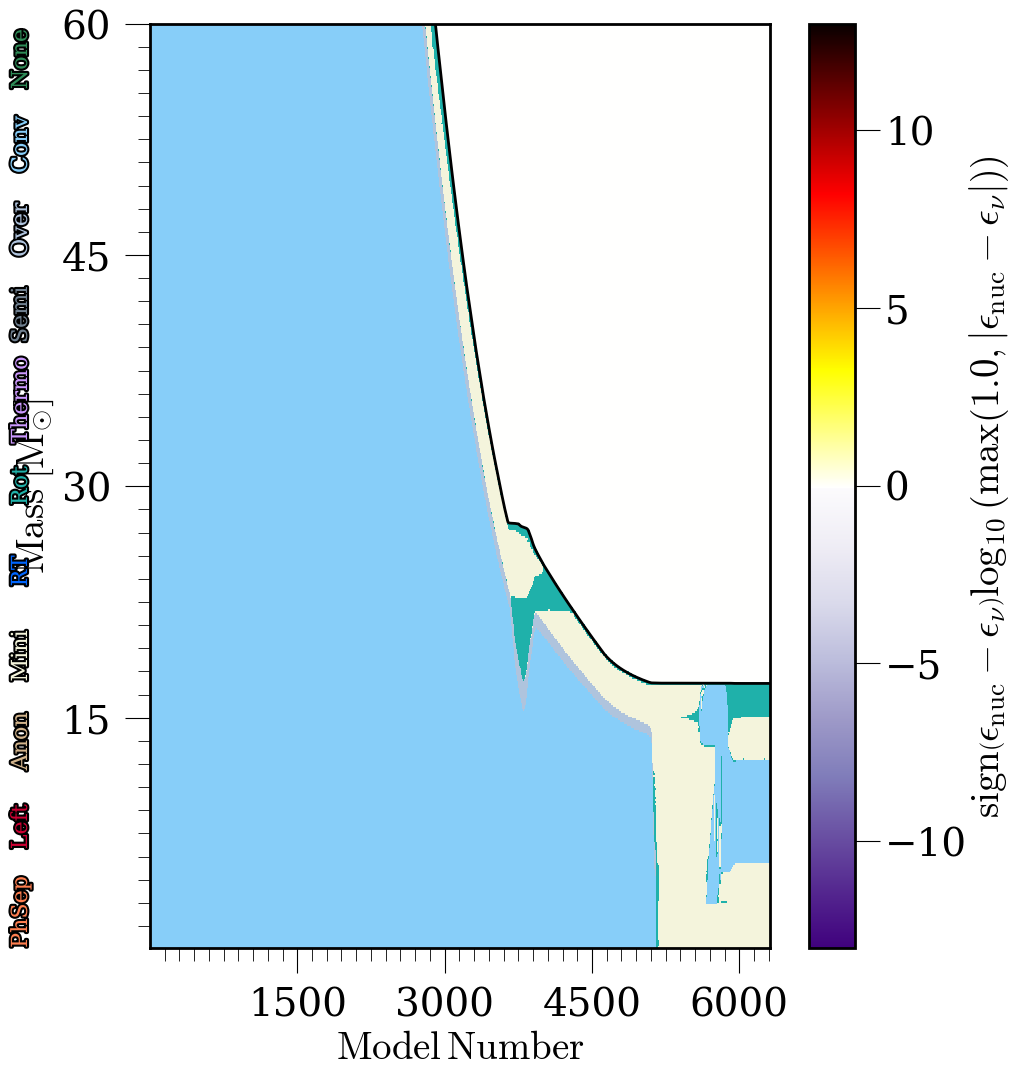

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_04zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


2385.0


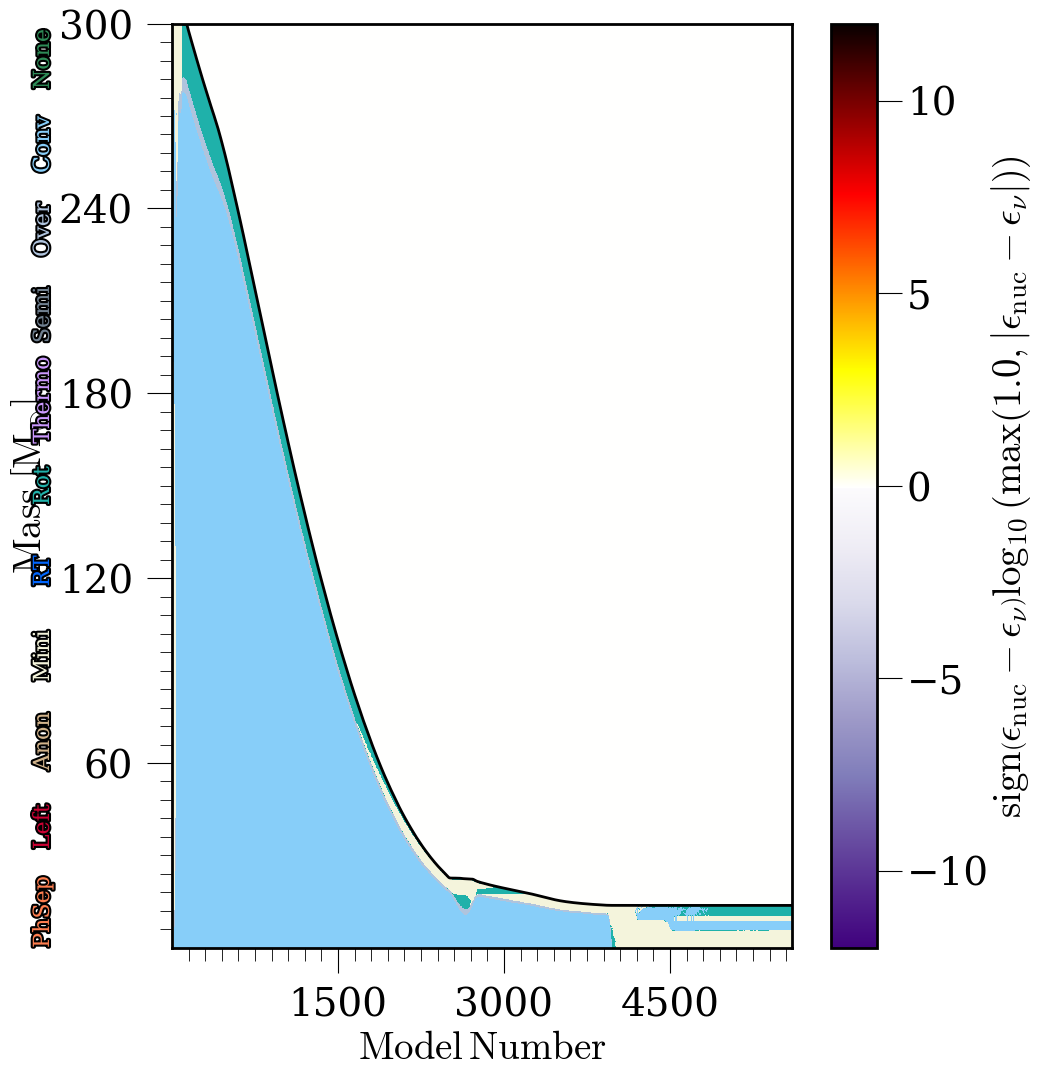

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_06zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


2385.0


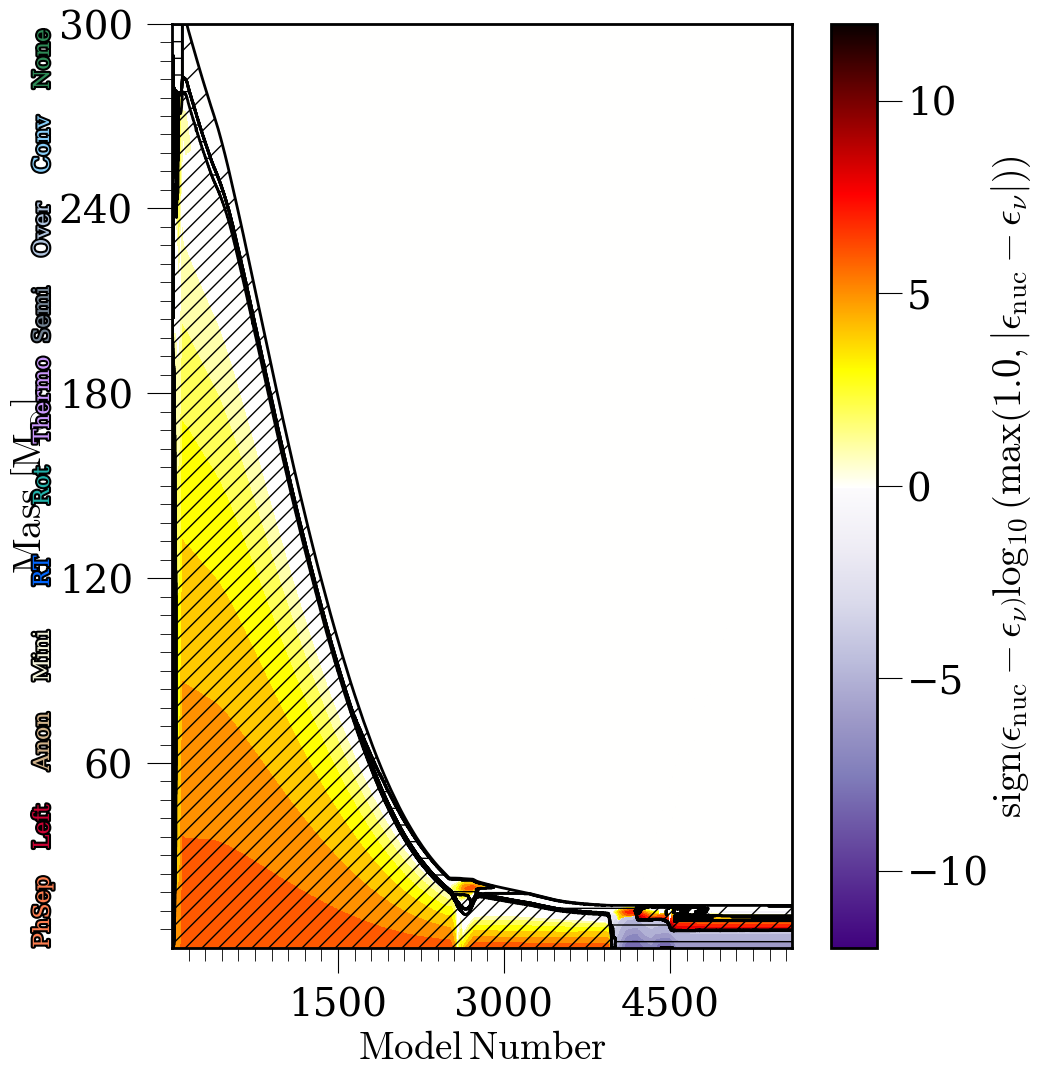

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 300)

model_dicts = model_dicts_06zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2385.0


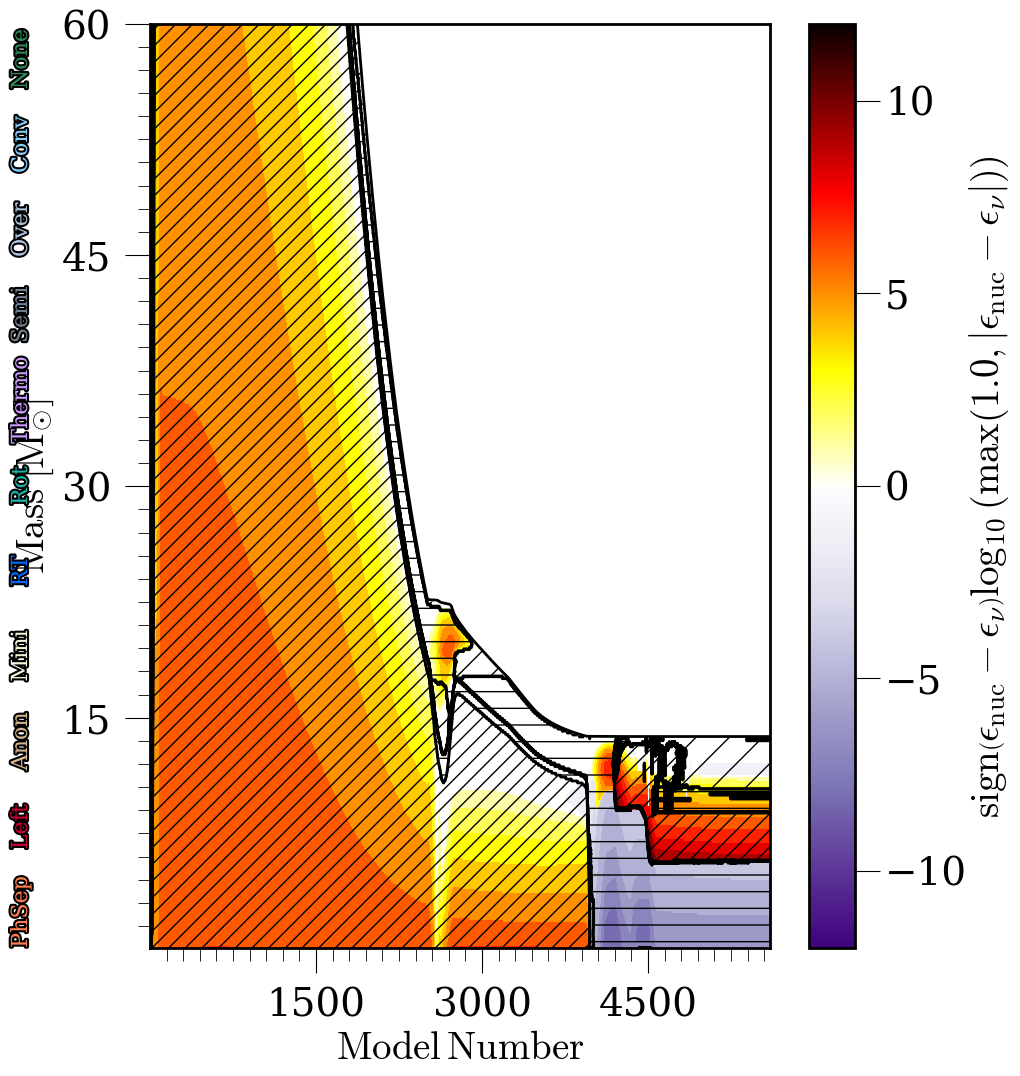

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_06zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


2352.0


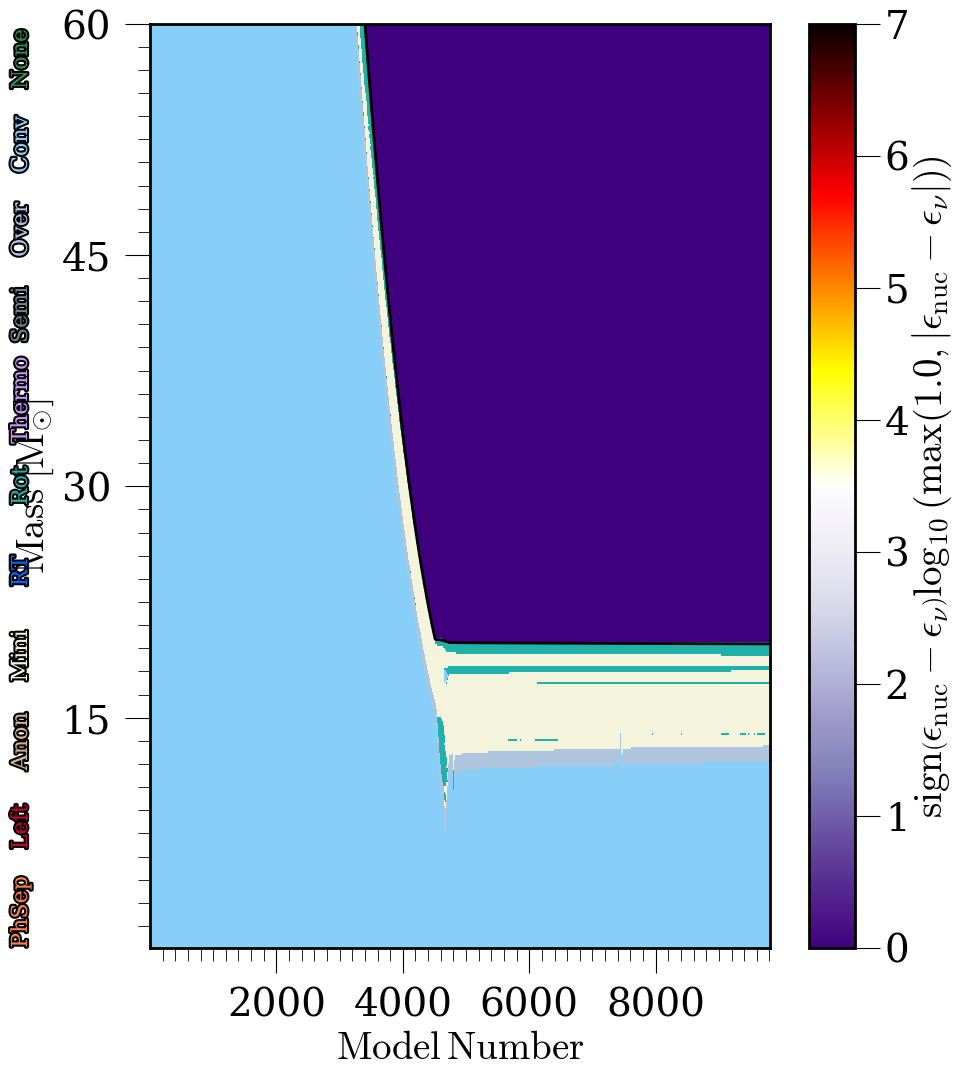

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_08zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=False, y1log=False, ax=ax)


2352.0


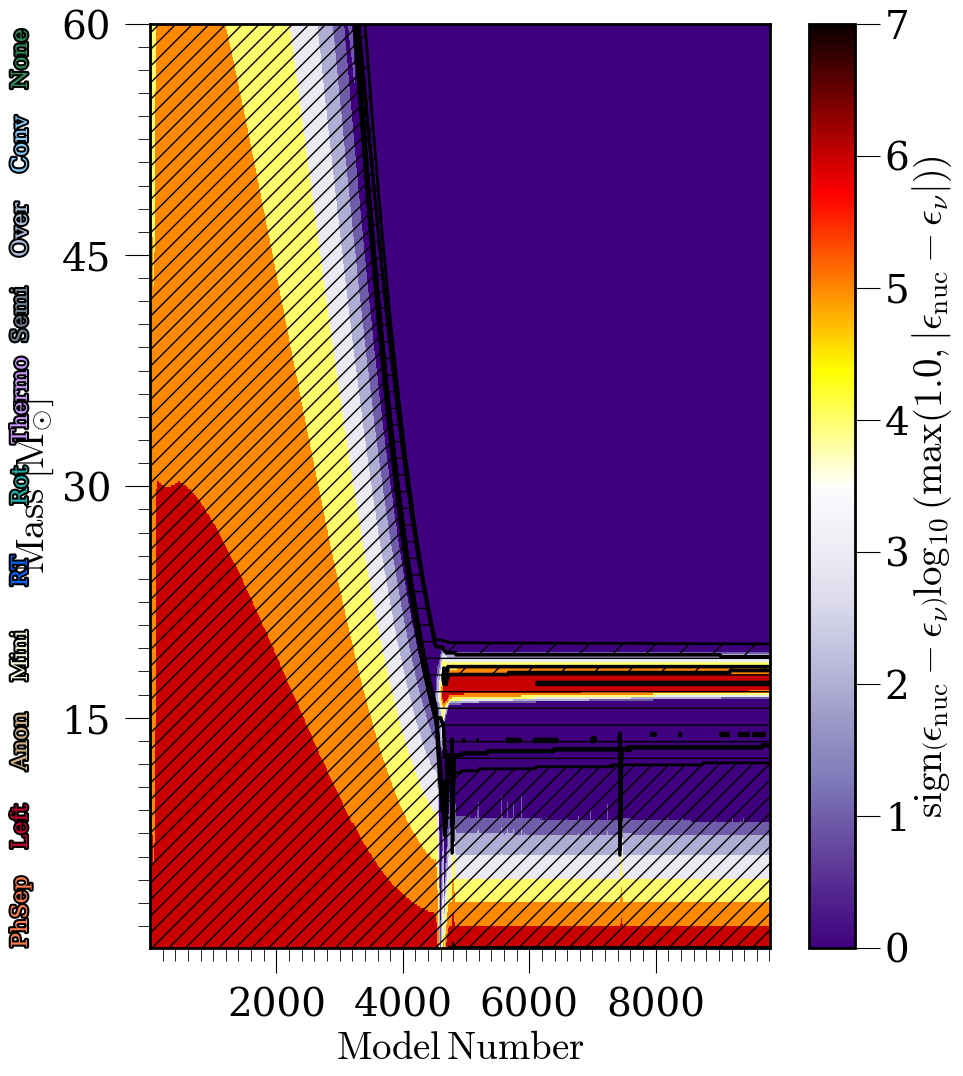

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_08zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


In [ ]:
test_case = model_dicts_08zsun[-1]['300.0']['3.00']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(0.0, 50.0)

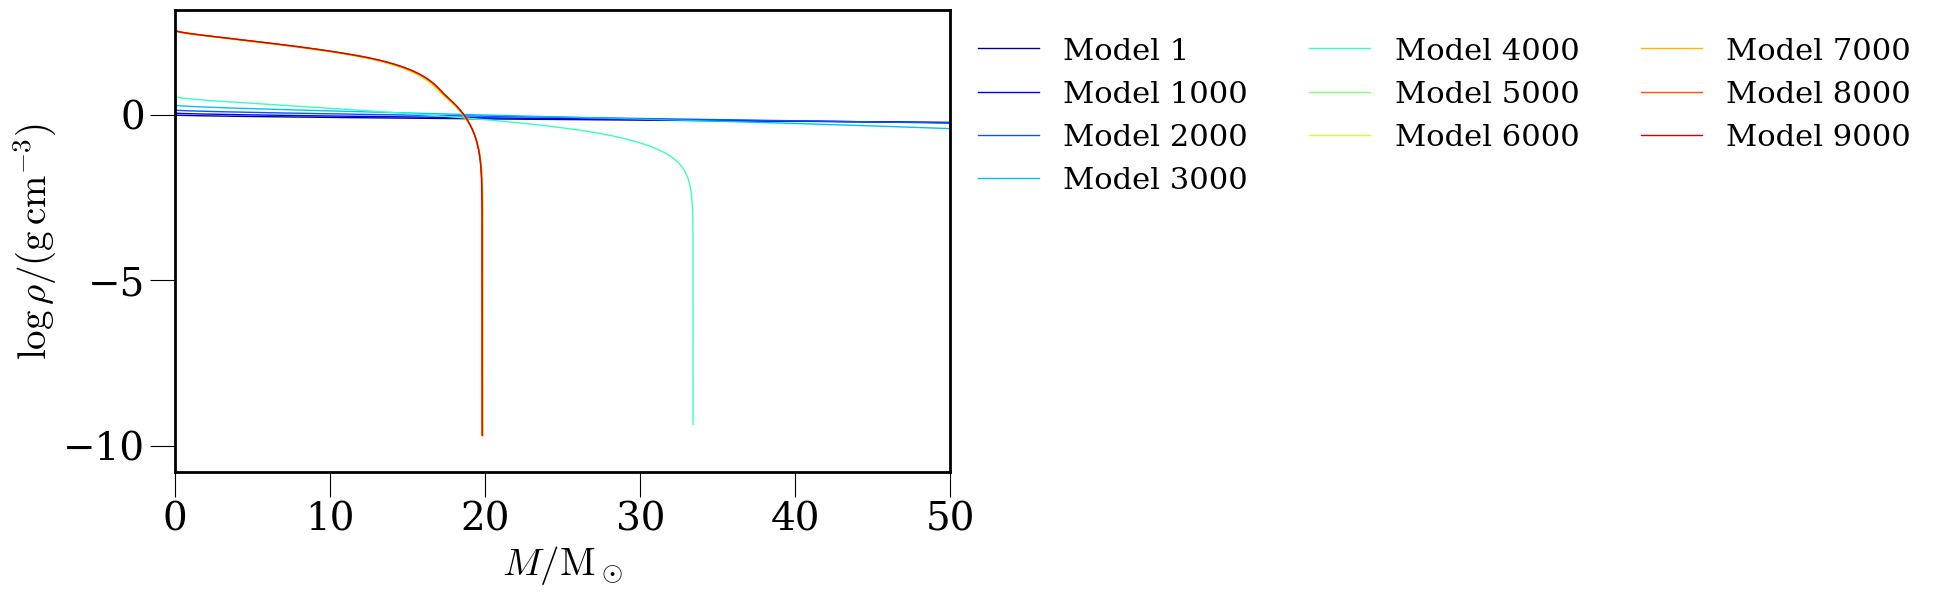

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[::10]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.logRho, c=c, label=f'Model {prof.model_number}', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log \\rho/(\\mathrm{g}\\,\\mathrm{cm}^{-3})$')
#ax.set_ylim(15, 20)
ax.set_xlim(0, 50)
    

2319.0


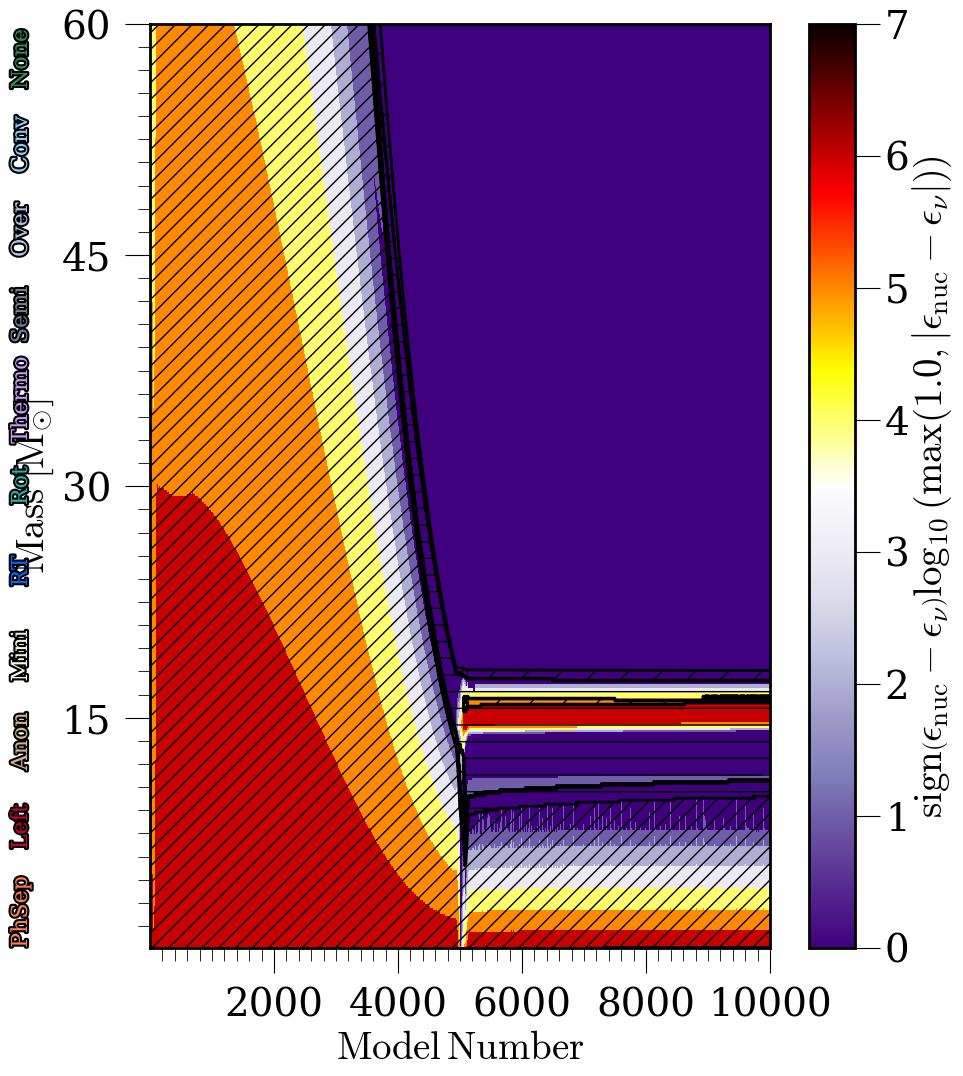

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 60)

model_dicts = model_dicts_10zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax)


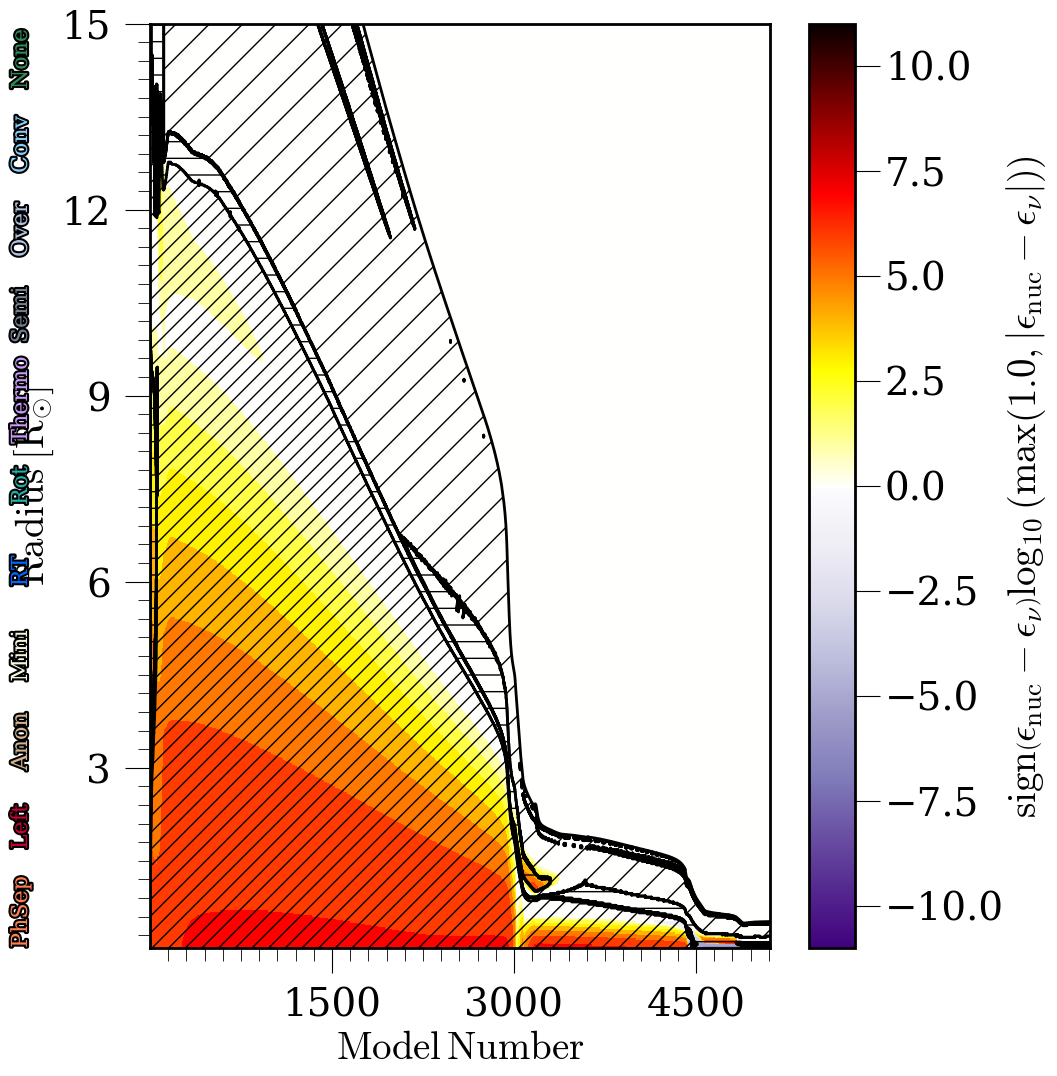

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 15)

model_dicts = model_dicts_02zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax, yaxis='radius')


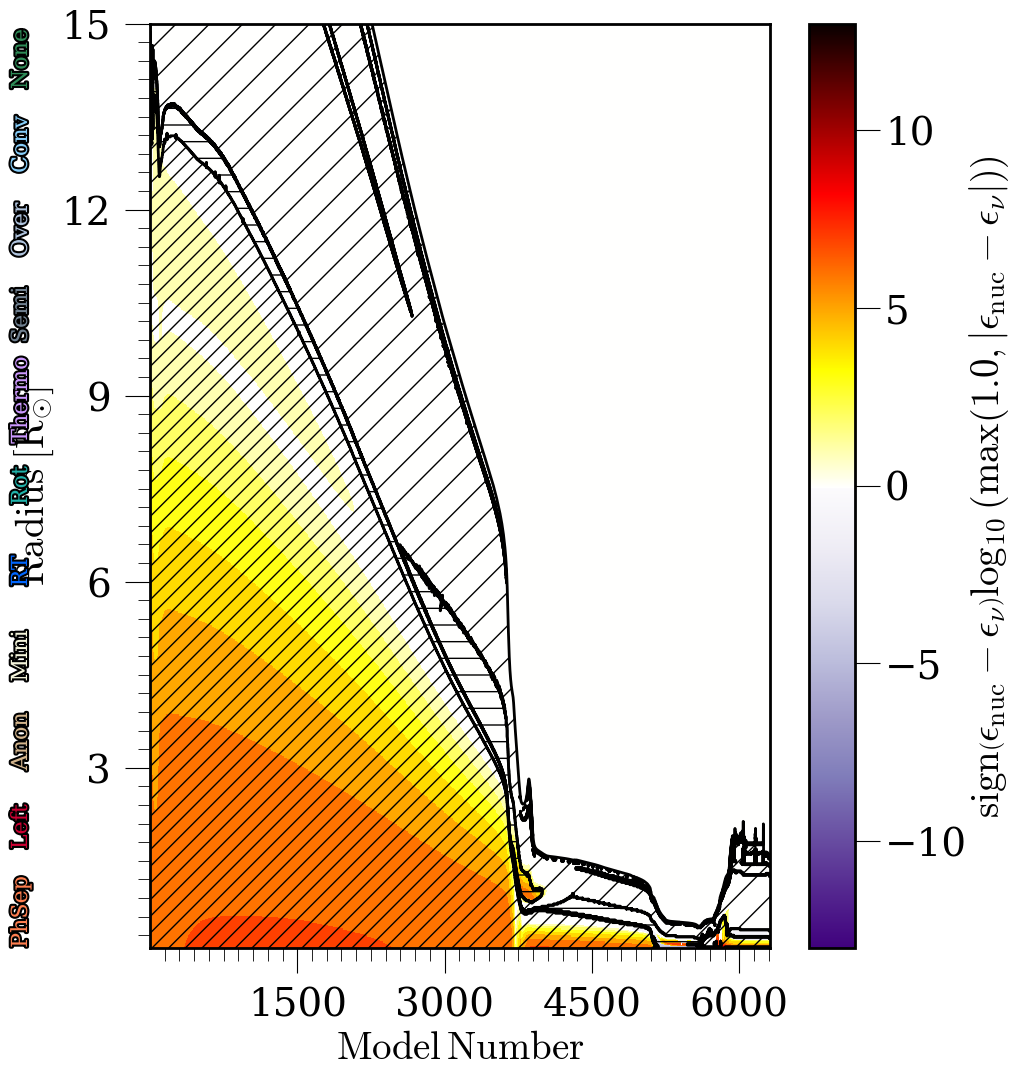

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 15)

model_dicts = model_dicts_04zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax, yaxis='radius')


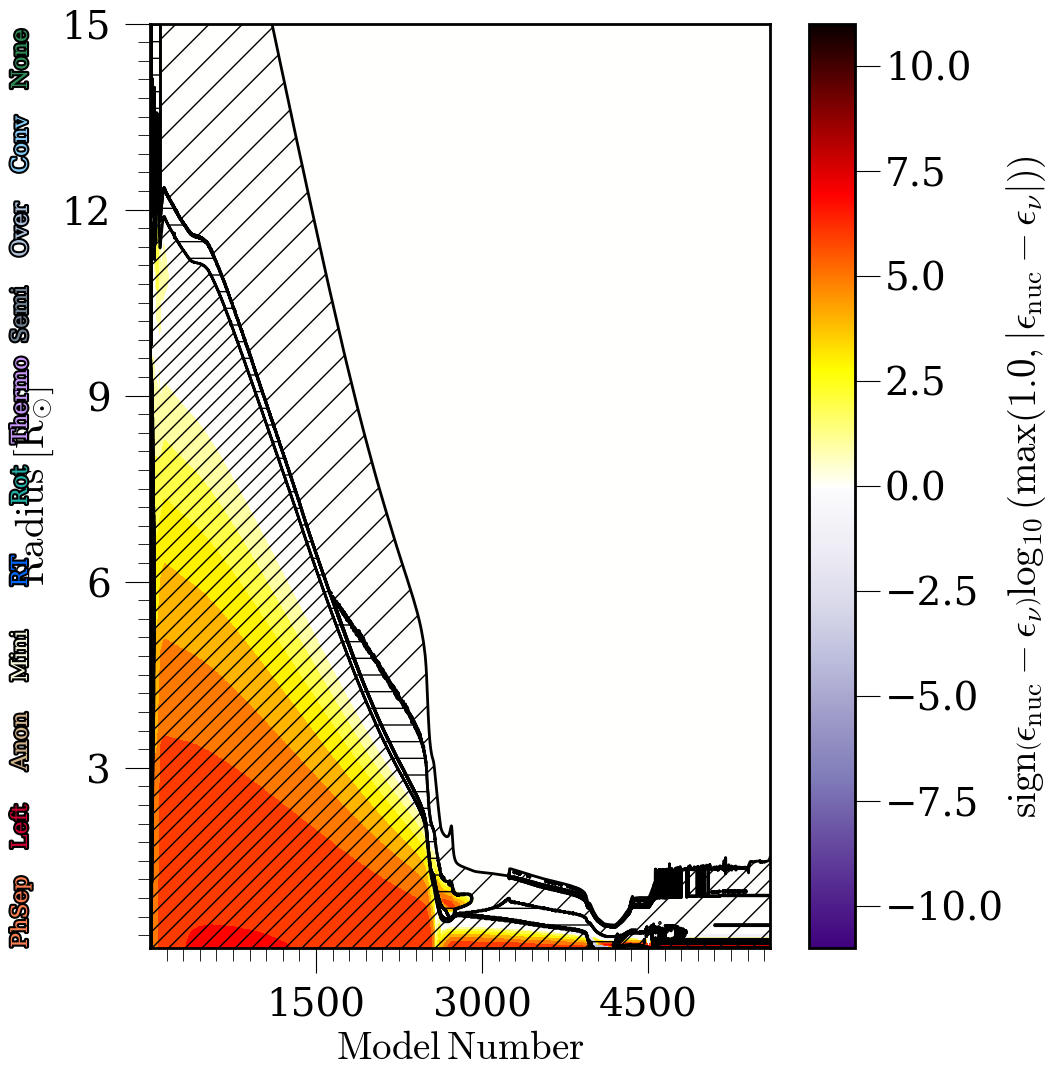

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 15)

model_dicts = model_dicts_06zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax, yaxis='radius')


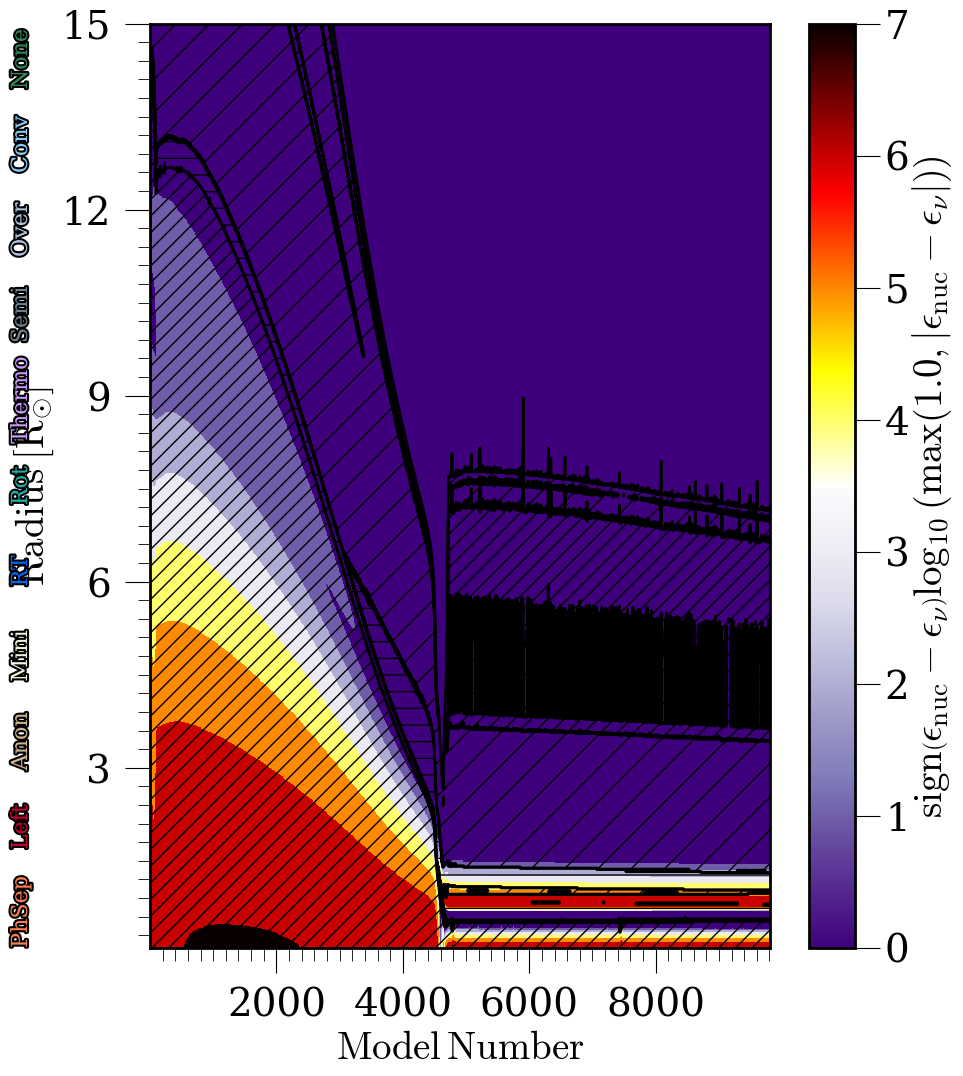

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 15)

model_dicts = model_dicts_08zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax, yaxis='radius')


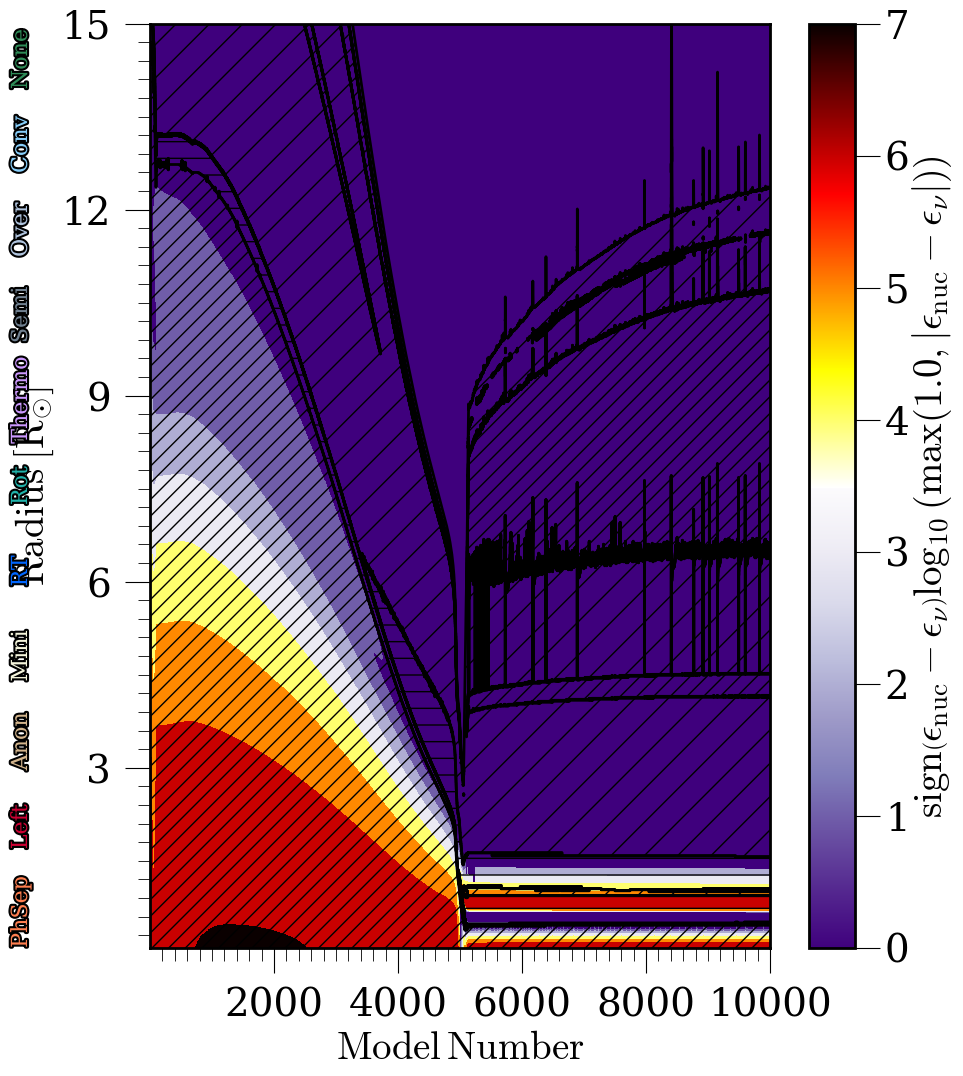

In [ ]:
fig,ax  = plt.subplots(figsize=(10,12))
ax.set_ylim(1e-1, 15)

model_dicts = model_dicts_10zsun
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[-1]['300.0']['3.00']/'LOGS'))
p = mp.plot()
p.plotKip3(mm, fig=fig, show_mix=True, mix_hatch=True, y1log=False, ax=ax, yaxis='radius')


In [ ]:
def plot_profiles(ax, model_dicts, id, mass, period, x, y, models_to_plot, mtp_mode='start_stop_step', cmap=cm.jet):
    test_case = model_dicts[id][mass][period]
    h = mr.MesaData(str(test_case/'LOGS/history.data'))
    logs = mr.MesaLogDir(str(test_case/'LOGS'))
    profile_numbers = logs.profile_numbers

    if mtp_mode == 'start_stop_step':
        prof_nos_to_plot = profile_numbers[models_to_plot[0]:models_to_plot[1]:models_to_plot[2]]
    elif mtp_mode == 'list':
        prof_nos_to_plot = profile_numbers[models_to_plot]
    else:
        raise ValueError(f'mtp_mode must be list or start_stop_step, not {mtp_mode}')
    
    for i, n in enumerate(prof_nos_to_plot):
        c = cmap(i/len(prof_nos_to_plot))
        prof = logs.profile_data(profile_number=n)
        x_data = eval(mesareader_operator(x, object_to_call='prof'))
        y_data = eval(mesareader_operator(y, object_to_call='prof'))
        ax.plot(x_data, y_data, c=c, label=f'M{prof.model_number}', lw=1)
        
    return ax
        

In [ ]:
template_h = mr.MesaData(str(model_dicts[6]['80.0']['1.00']/'LOGS/history.data'))
template_logs = mr.MesaLogDir(str(model_dicts[6]['80.0']['1.00']/'LOGS'))
template_prof = template_logs.profile_data(profile_number=1)

In [ ]:
template_prof.bulk_names

('zone',
 'mass',
 'logR',
 'logT',
 'logRho',
 'logP',
 'x_mass_fraction_H',
 'y_mass_fraction_He',
 'z_mass_fraction_metals',
 'dm',
 'logdq',
 'log_g',
 'radius',
 'velocity',
 'scale_height',
 'pressure_scale_height',
 'dq',
 'energy',
 'entropy',
 'prad',
 'pgas',
 'pgas_div_ptotal',
 'eta',
 'mu',
 'grada',
 'dE_dRho',
 'cp',
 'gamma1',
 'csound',
 'v_div_cs',
 'net_nuclear_energy',
 'net_energy',
 'eps_nuc',
 'non_nuc_neu',
 'pp',
 'cno',
 'tri_alpha',
 'c_alpha',
 'n_alpha',
 'o_alpha',
 'ne_alpha',
 'na_alpha',
 'mg_alpha',
 'si_alpha',
 's_alpha',
 'ar_alpha',
 'ca_alpha',
 'ti_alpha',
 'cr_alpha',
 'fe_co_ni',
 'c12_c12',
 'c12_o16',
 'o16_o16',
 'pnhe4',
 'photo',
 'ni56_co56',
 'co56_fe56',
 'other',
 'abar',
 'zbar',
 'z2bar',
 'ye',
 'neut',
 'h1',
 'h2',
 'he3',
 'he4',
 'li7',
 'be7',
 'be9',
 'be10',
 'b8',
 'c12',
 'c13',
 'n13',
 'n14',
 'n15',
 'o14',
 'o15',
 'o16',
 'o17',
 'o18',
 'f17',
 'f18',
 'f19',
 'ne18',
 'ne19',
 'ne20',
 'ne21',
 'ne22',
 'na21',
 'na2

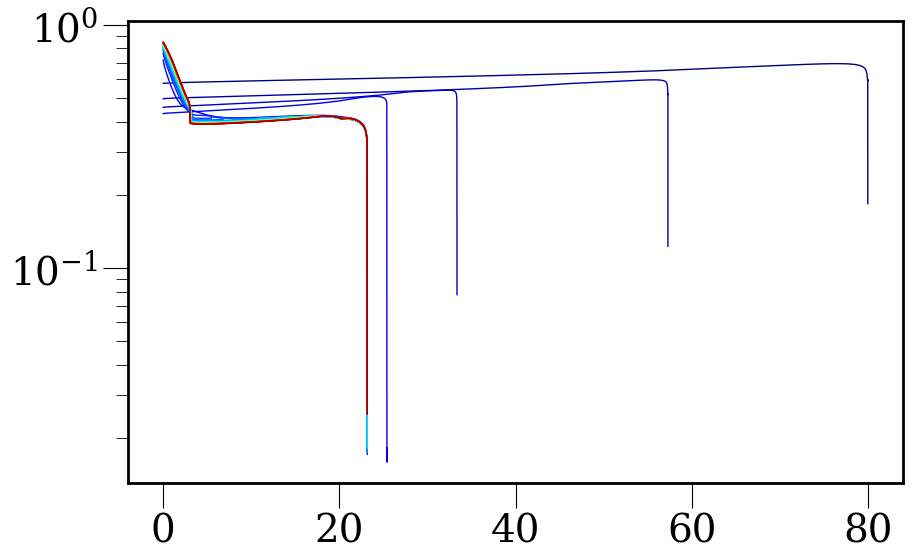

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax = plot_profiles(ax, model_dicts_02zsun, 6, '80.0', '1.00', 'mass', 'pgas_div_ptotal', (0, -1, 10))
ax.set_yscale('log')

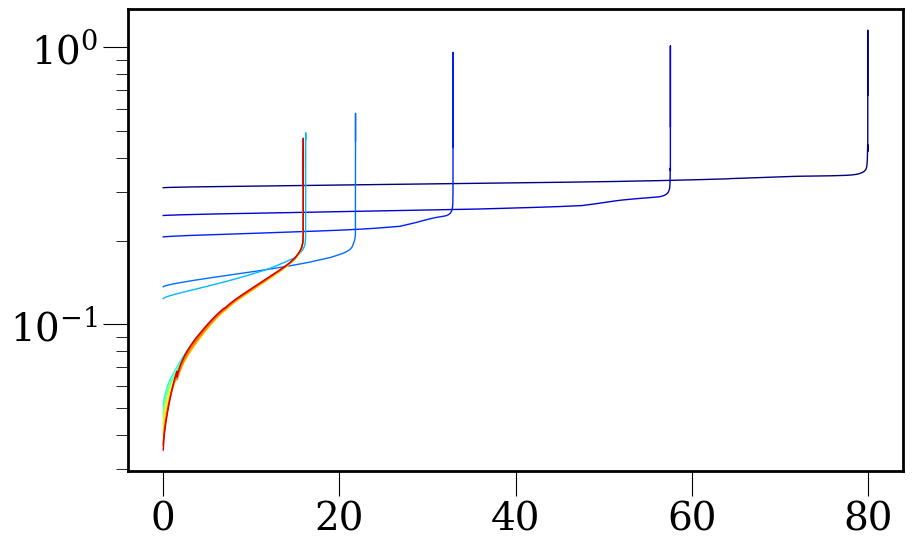

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax = plot_profiles(ax, model_dicts_04zsun, 6, '80.0', '1.00', 'mass', 'opacity', (0, -1, 10))
ax.set_yscale('log')

In [ ]:
test_case = model_dicts_04zsun[6]['80.0']['1.00']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(0.0, 90.0)

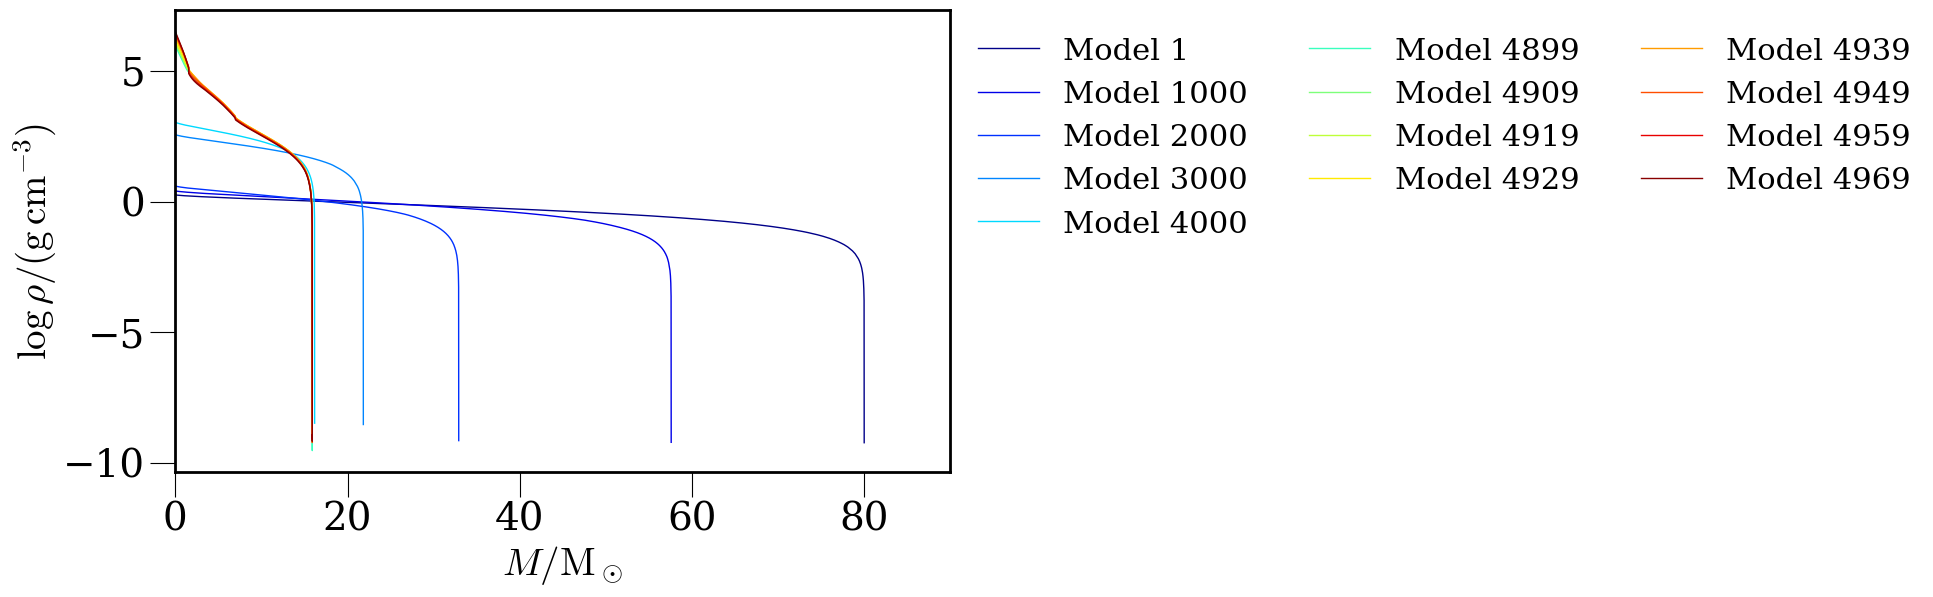

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[::10]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.logRho, c=c, label=f'Model {prof.model_number}', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log \\rho/(\\mathrm{g}\\,\\mathrm{cm}^{-3})$')
#ax.set_ylim(15, 20)
ax.set_xlim(0, 90)
    

## Crash tests

In [ ]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_base = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_mlt = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/22_Zdiv_Zsun_1d0_mlt'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_mlt10 = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/31_Zdiv_Zsun_8d-1_thermohaline'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_thermohaline = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_md125 = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_md150 = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/43_Zdiv_Zsun_8d-1_lowres_md175'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_md175 = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/44_Zdiv_Zsun_8d-1_lowres_md200'

model_ids = np.arange(1, 4, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_md200 = model_dicts

No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1
No matches found in /mnt/ceph/users/ldesa/mesa

AttributeError: 'NoneType' object has no attribute 'glob'

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv

Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

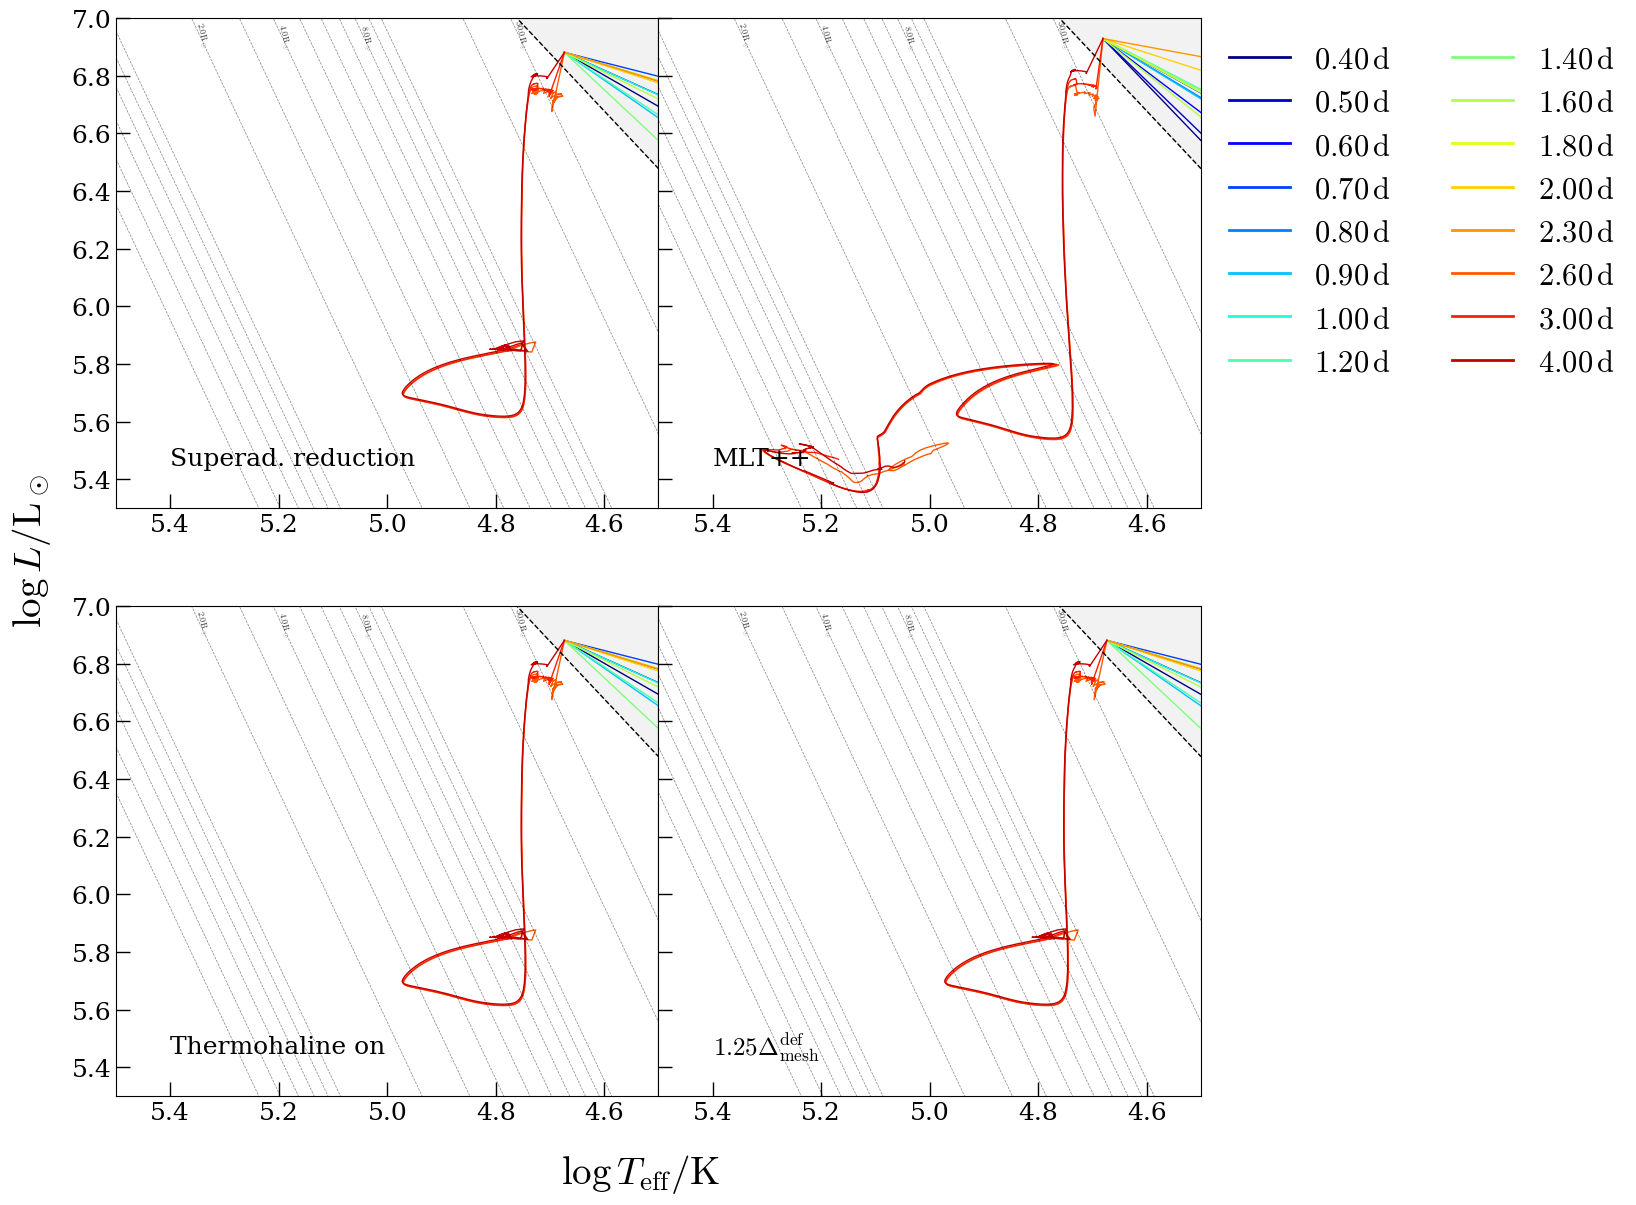

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5.3, 7)

mass_id_to_plot = -1
models_to_plot = [mass_id_to_plot]
model_style_list = ['-']
    
model_dicts_to_plot = np.array([
    model_dicts_base[[4,7,9]],
    model_dicts_mlt10,
    model_dicts_base[[4,7,9]],
    model_dicts_base[[4,7,9]],
])

model_labels = np.array([
    'Superad. reduction',
    'MLT++',
    'Thermohaline on',
    '$1.25\Delta_\mathrm{mesh}^\mathrm{def}$'
])


for i, (ax, model_dicts, label) in enumerate(zip(axes.flatten(), model_dicts_to_plot, model_labels)):
    if i == 1:
        legend = True
    else:
        legend = False
               
    print(model_dicts, label, models_to_plot, model_style_list)
    ax, handles = hr_diagram_tracks(
        model_dicts=model_dicts,
        model_labels=np.array([label]),
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_mass_comparison')


[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grid

Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

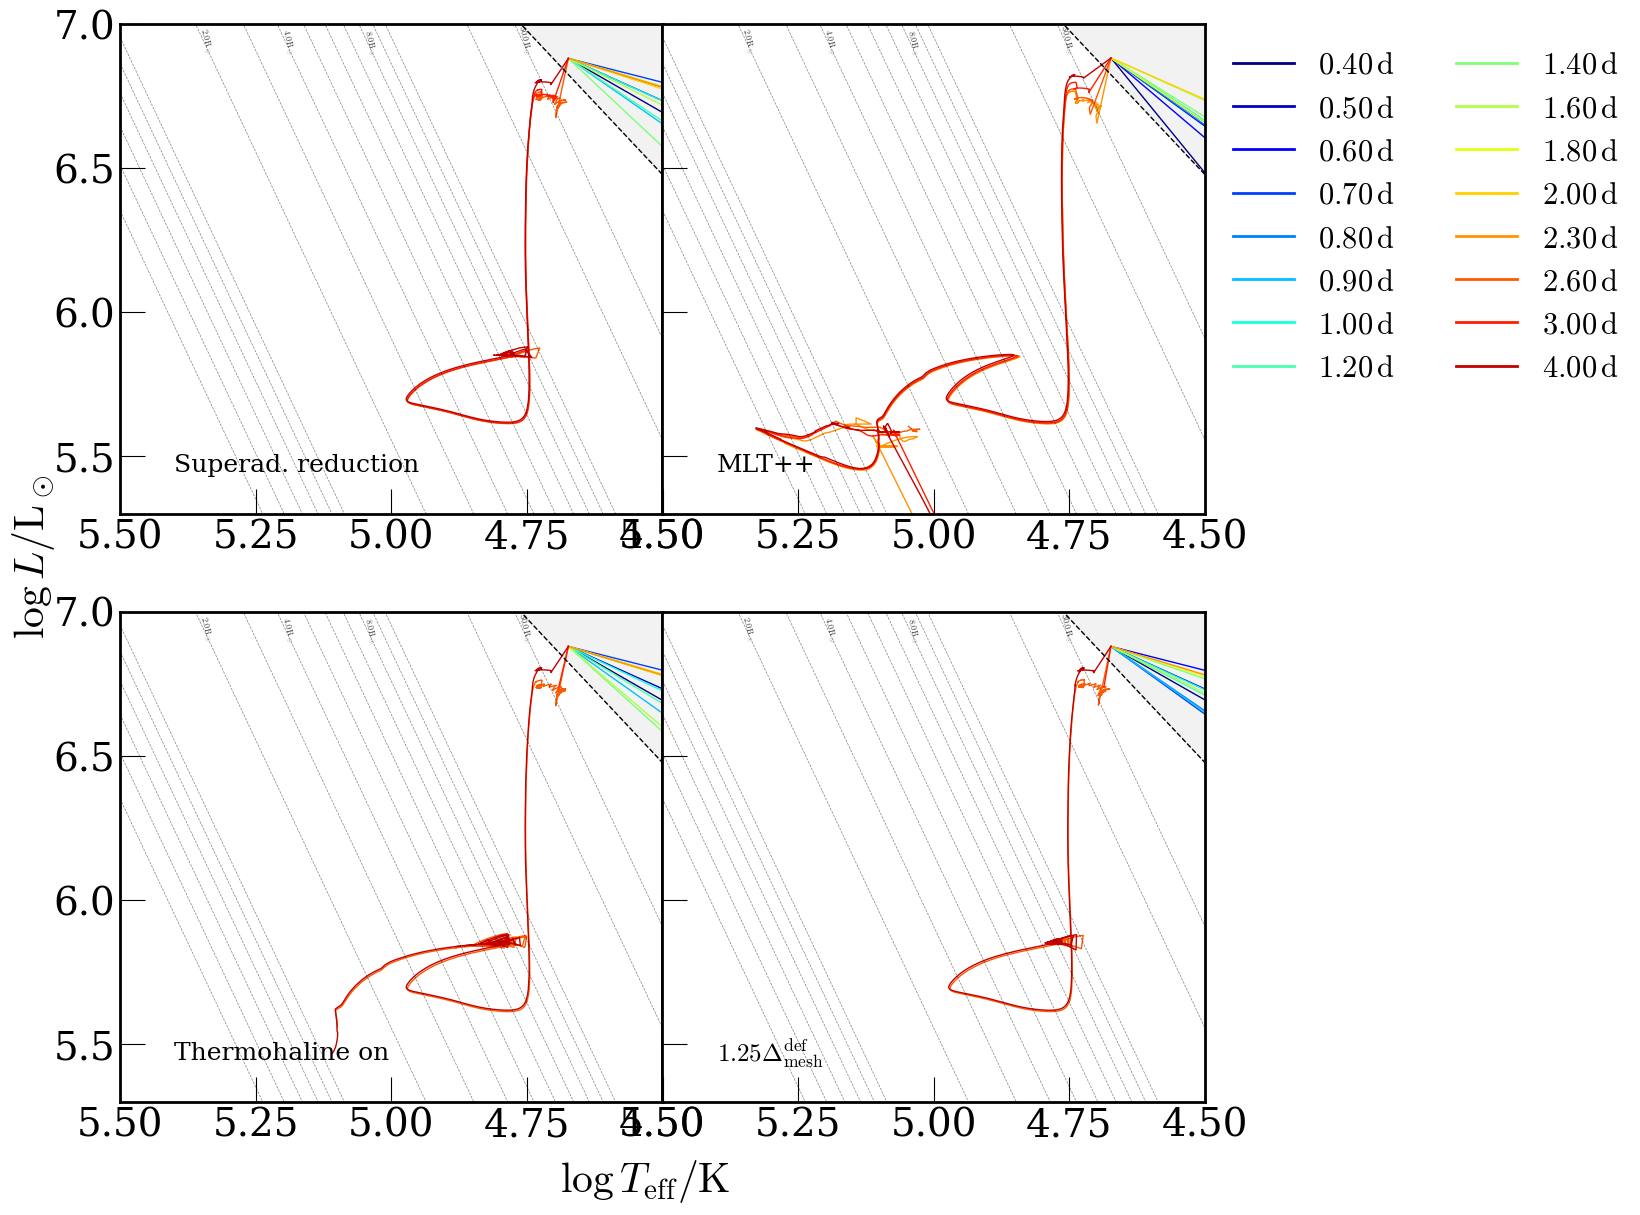

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5.3, 7)

mass_id_to_plot = -1
models_to_plot = [mass_id_to_plot]
model_style_list = ['-']
    
model_dicts_to_plot = np.array([
    model_dicts_base[[4,7,9]],
    model_dicts_mlt,
    model_dicts_thermohaline,
    model_dicts_md125
])

model_labels = np.array([
    'Superad. reduction',
    'MLT++',
    'Thermohaline on',
    '$1.25\Delta_\mathrm{mesh}^\mathrm{def}$'
])


for i, (ax, model_dicts, label) in enumerate(zip(axes.flatten(), model_dicts_to_plot, model_labels)):
    if i == 1:
        legend = True
    else:
        legend = False
               
    print(model_dicts, label, models_to_plot, model_style_list)
    ax, handles = hr_diagram_tracks(
        model_dicts=model_dicts,
        model_labels=np.array([label]),
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_mass_comparison')


[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/41_Zdiv_Zsun_8d-1_lowres_md125/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grid

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/42_Zdiv_Zsun_8d-1_lowres_md150/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grid

Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

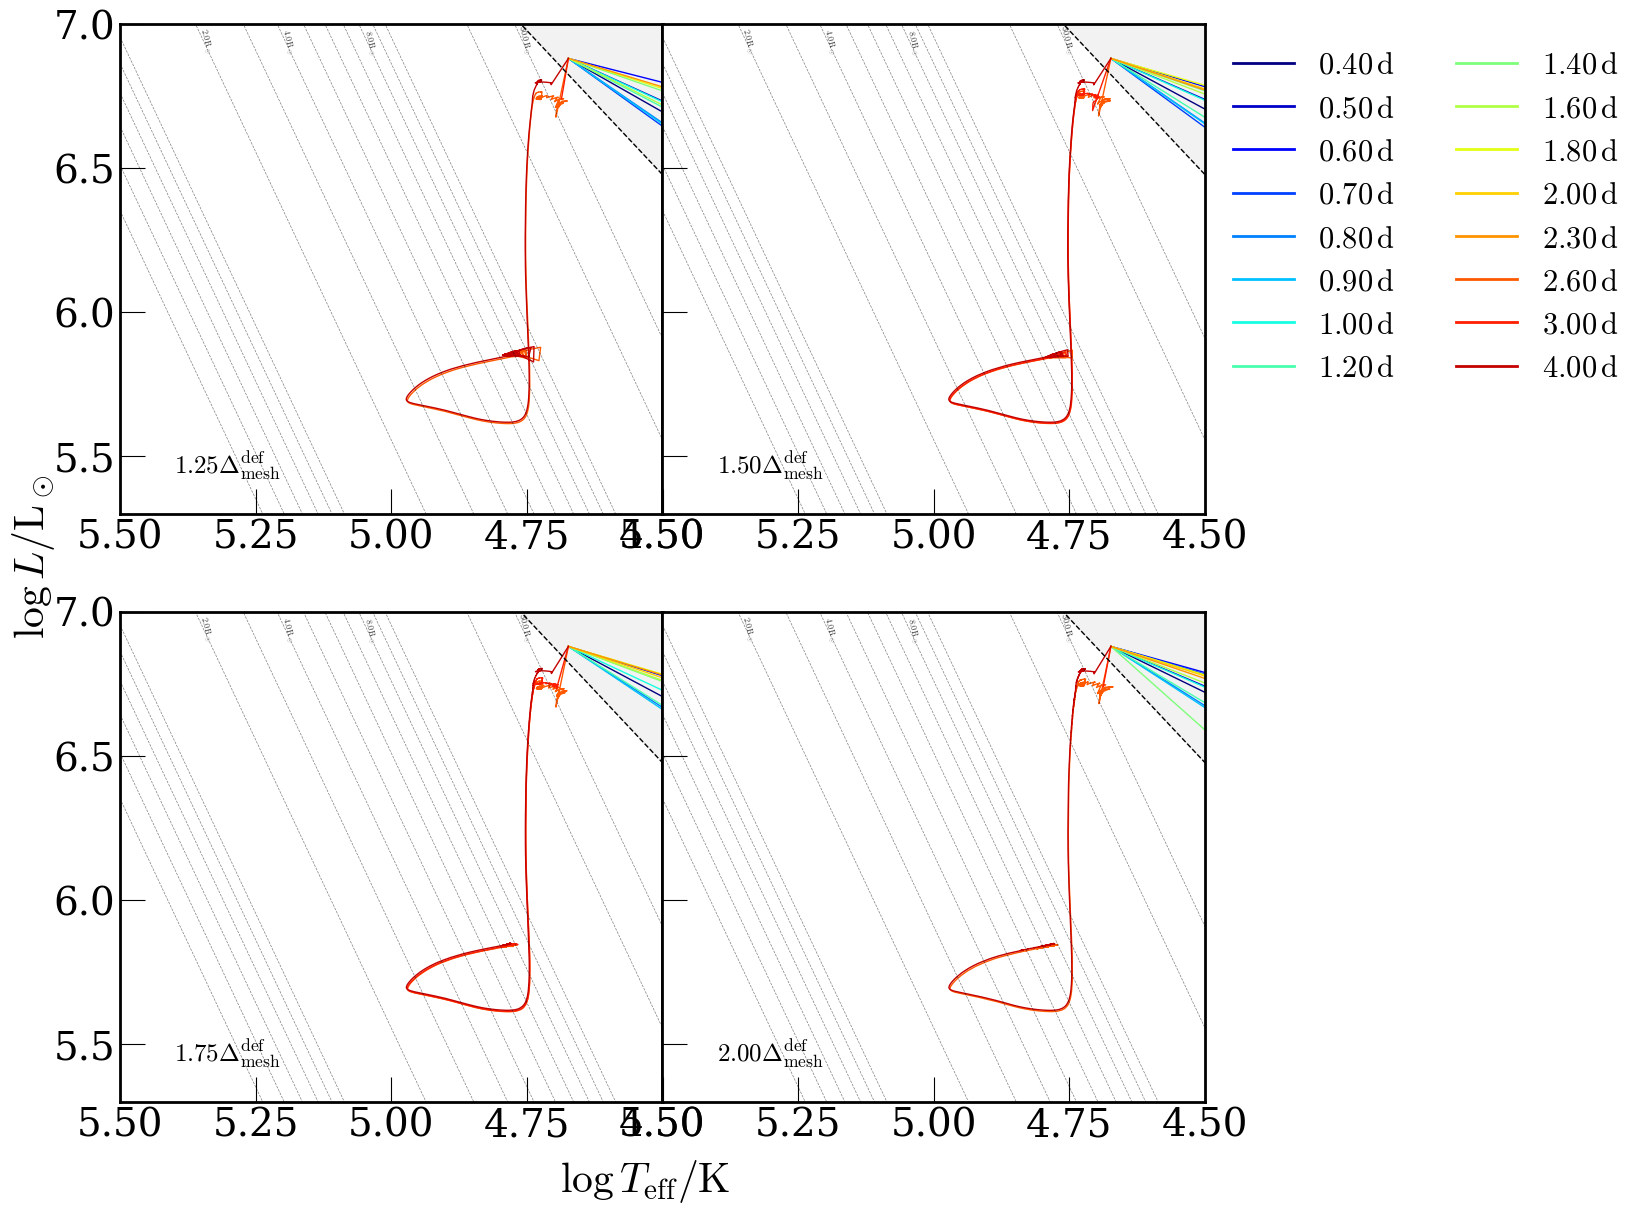

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5.3, 7)

mass_id_to_plot = -1
models_to_plot = [mass_id_to_plot]
model_style_list = ['-']
    
model_dicts_to_plot = np.array([
    model_dicts_md125,
    model_dicts_md150,
    model_dicts_md175,
    model_dicts_md200
])

model_labels = np.array([
    '$1.25\Delta_\mathrm{mesh}^\mathrm{def}$',
    '$1.50\Delta_\mathrm{mesh}^\mathrm{def}$',
    '$1.75\Delta_\mathrm{mesh}^\mathrm{def}$',
    '$2.00\Delta_\mathrm{mesh}^\mathrm{def}$'
])


for i, (ax, model_dicts, label) in enumerate(zip(axes.flatten(), model_dicts_to_plot, model_labels)):
    if i == 1:
        legend = True
    else:
        legend = False
               
    print(model_dicts, label, models_to_plot, model_style_list)
    ax, handles = hr_diagram_tracks(
        model_dicts=model_dicts,
        model_labels=np.array([label]),
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_mass_comparison')


[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsu

Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

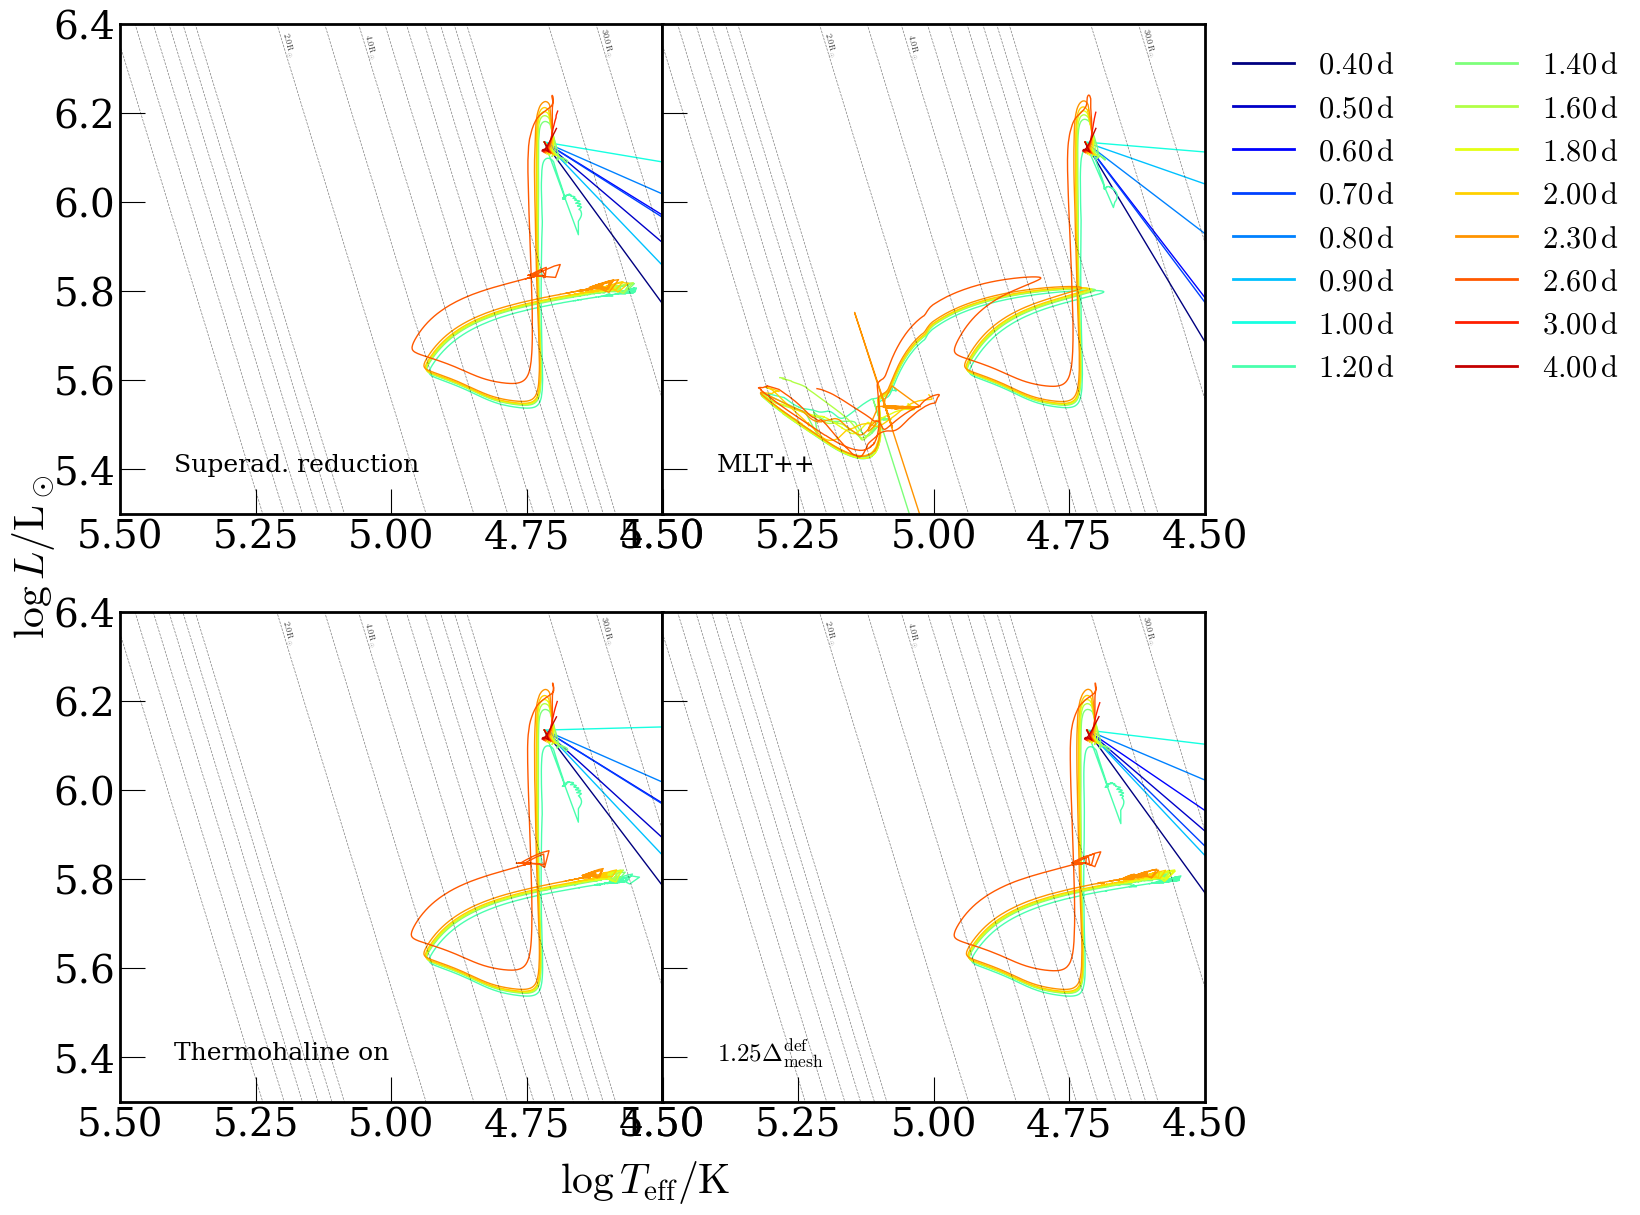

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5.3, 6.4)

mass_id_to_plot = 1
models_to_plot = [mass_id_to_plot]
model_style_list = ['-']
    
model_dicts_to_plot = np.array([
    model_dicts_base[[4,7,9]],
    model_dicts_mlt,
    model_dicts_thermohaline,
    model_dicts_md125
])

model_labels = np.array([
    'Superad. reduction',
    'MLT++',
    'Thermohaline on',
    '$1.25\Delta_\mathrm{mesh}^\mathrm{def}$'
])


for i, (ax, model_dicts, label) in enumerate(zip(axes.flatten(), model_dicts_to_plot, model_labels)):
    if i == 1:
        legend = True
    else:
        legend = False
               
    print(model_dicts, label, models_to_plot, model_style_list)
    ax, handles = hr_diagram_tracks(
        model_dicts=model_dicts,
        model_labels=np.array([label]*3),
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_mass_comparison')


[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_8d-1/005_md1_m60_zsundiv

[{'60.0': {'1.80': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.800d+00_w4.040d-05'), '1.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.400d+00_w5.194d-05'), '0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p9.000d-01_w8.080d-05'), '0.50': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p5.000d-01_w1.454d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsun_8d-1_mlt/001_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p1.600d+00_w4.545d-05'), '2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/21_Zdiv_Zsu

Text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

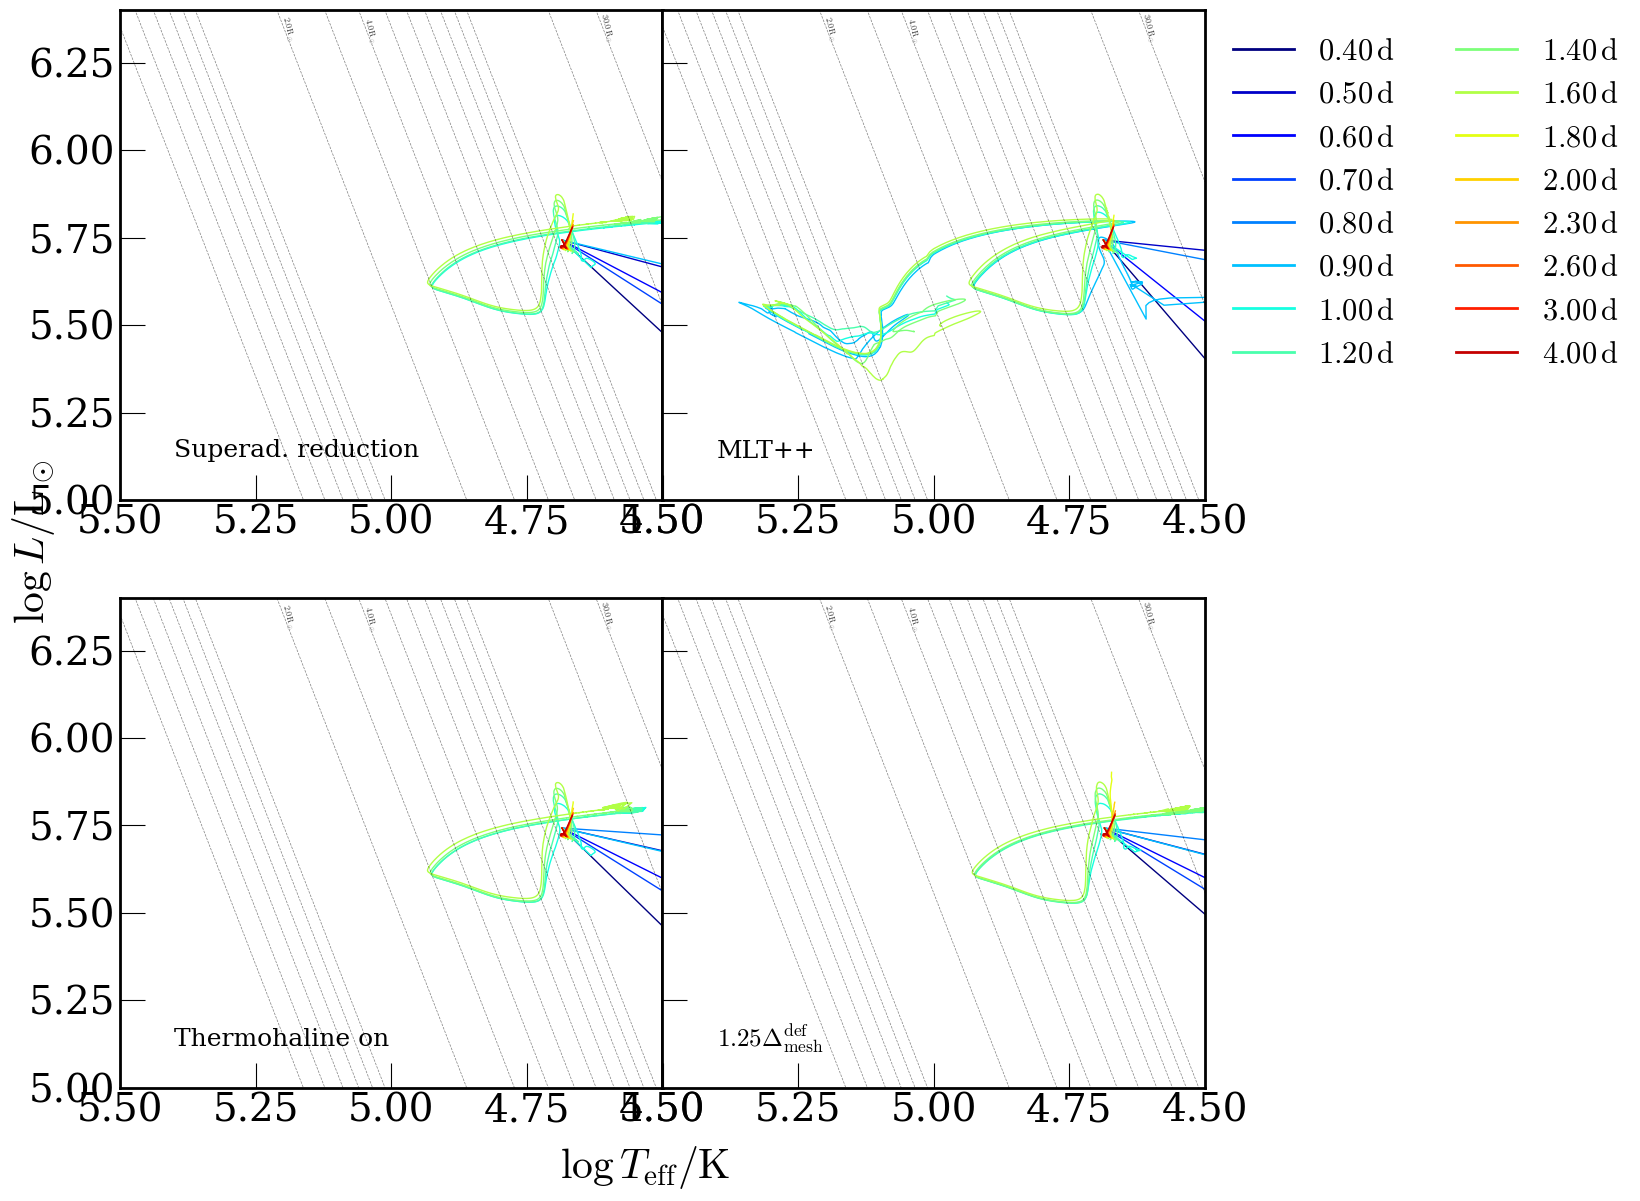

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (5, 6.4)

mass_id_to_plot = 0
models_to_plot = [mass_id_to_plot]
model_style_list = ['-']
    
model_dicts_to_plot = np.array([
    model_dicts_base[[4,7,9]],
    model_dicts_mlt,
    model_dicts_thermohaline,
    model_dicts_md125
])

model_labels = np.array([
    'Superad. reduction',
    'MLT++',
    'Thermohaline on',
    '$1.25\Delta_\mathrm{mesh}^\mathrm{def}$'
])


for i, (ax, model_dicts, label) in enumerate(zip(axes.flatten(), model_dicts_to_plot, model_labels)):
    if i == 1:
        legend = True
    else:
        legend = False
               
    print(model_dicts, label, models_to_plot, model_style_list)
    ax, handles = hr_diagram_tracks(
        model_dicts=model_dicts,
        model_labels=np.array([label]),
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

#savefig(fig, 'hr_allp_mass_comparison')


In [ ]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m * a
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q, t1
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

In [ ]:
def coalescence_time(m, a, q):
    m = fix_unit(m, u.Msun)
    a = fix_unit(a, u.Rsun)
    c = 5/256 * ct.c**5 / ct.G**3
    mass_term = m * q*m * (q + 1)*m
    td = c * a**4 / mass_term
    return td.to(u.yr).value

In [ ]:
mps_i_f_arr = np.zeros((48,11))

m_keys = np.array(list(model_dicts.keys()))
mi_arr = np.float32(m_keys)
m_keys = m_keys[np.argsort(mi_arr)]
mi_arr = np.sort(mi_arr)

i = 0
for m_key in m_keys:
    mi = float(m_key)
    dict_ = model_dicts[m_key]
    
    p_keys = np.array(list(dict_.keys()))
    pi_arr = np.float32(p_keys)
    p_keys = p_keys[np.argsort(pi_arr)]
    pi_arr = np.sort(pi_arr)
    for p_key in p_keys:
        pi = float(p_key)
        qi = 1.0
        ai = a_from_p(pi, mi, qi).to(u.Rsun).value
        
        model_path = dict_[p_key]
        try:
            h = mr.MesaData(str(model_path/'LOGS/history.data'))
        except:
            stop = 0
            print(f'Stop {stop} for {mi, pi, ai}')
            mf = mi
            pf = pi
            af = ai
            qf = qi
            tf = 1e11
        else:
            w_div_wc = h.surf_avg_omega_div_omega_crit
            w_div_wc = w_div_wc[w_div_wc > 0]
            if w_div_wc[0] >= 1:
                stop = 0
                print(f'Stop {stop} for {mi, pi, ai}')
                mf = mi
                pf = pi
                af = ai
                qf = qi
                tf = 1e11
            else:
                x_cntr = h.center_h1
                if x_cntr[-1] > 1e-6:
                    stop = 1
                    print(f'Stop {stop} for {mi, pi, ai}')
                else:
                    stop = 2
                    print(f'Stop {stop} for {mi, pi, ai}')
                
                integrator = WindIntegrator(model_path)
                mf, pf, af, qf, tf = integrator.integrate(1e9)
        finally:
            print(f'Run {i} from {mi,pi,ai,qi} to {mf, pf, af, qf}')
            tc = coalescence_time(mf, af, qf)
            td = tf + tc
            mps_i_f_arr[i] = [mi, pi, ai, qi, mf, pf, af, qf, tc, td, stop]
            i += 1
            print('')
        
        

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
mps_i_f_arr_08zsun_test = mps_i_f_arr

array([[6.00000000e+01, 9.00000000e-01, 1.93490603e+01, 1.00000000e+00,
        1.59785304e+01, 1.35033071e+01, 7.57274785e+01, 1.00000000e+00,
        6.05419195e+11, 6.05424654e+11, 2.00000000e+00],
       [6.00000000e+01, 1.00000000e+00, 2.07570137e+01, 1.00000000e+00,
        1.12058380e+01, 2.88693864e+01, 1.11657424e+02, 1.00000000e+00,
        8.29602596e+12, 8.29603114e+12, 2.00000000e+00],
       [6.00000000e+01, 1.20000000e+00, 2.34397173e+01, 1.00000000e+00,
        1.09927237e+01, 3.57453802e+01, 1.27927184e+02, 1.00000000e+00,
        1.51421703e+13, 1.51421754e+13, 2.00000000e+00],
       [6.00000000e+01, 1.40000000e+00, 2.59766751e+01, 1.00000000e+00,
        1.06212300e+01, 4.46503591e+01, 1.46686236e+02, 1.00000000e+00,
        2.90192191e+13, 2.90192241e+13, 2.00000000e+00],
       [6.00000000e+01, 1.60000000e+00, 2.83951954e+01, 1.00000000e+00,
        1.10019028e+01, 4.75485100e+01, 1.54772928e+02, 1.00000000e+00,
        3.23615480e+13, 3.23615530e+13, 2.00000000e+

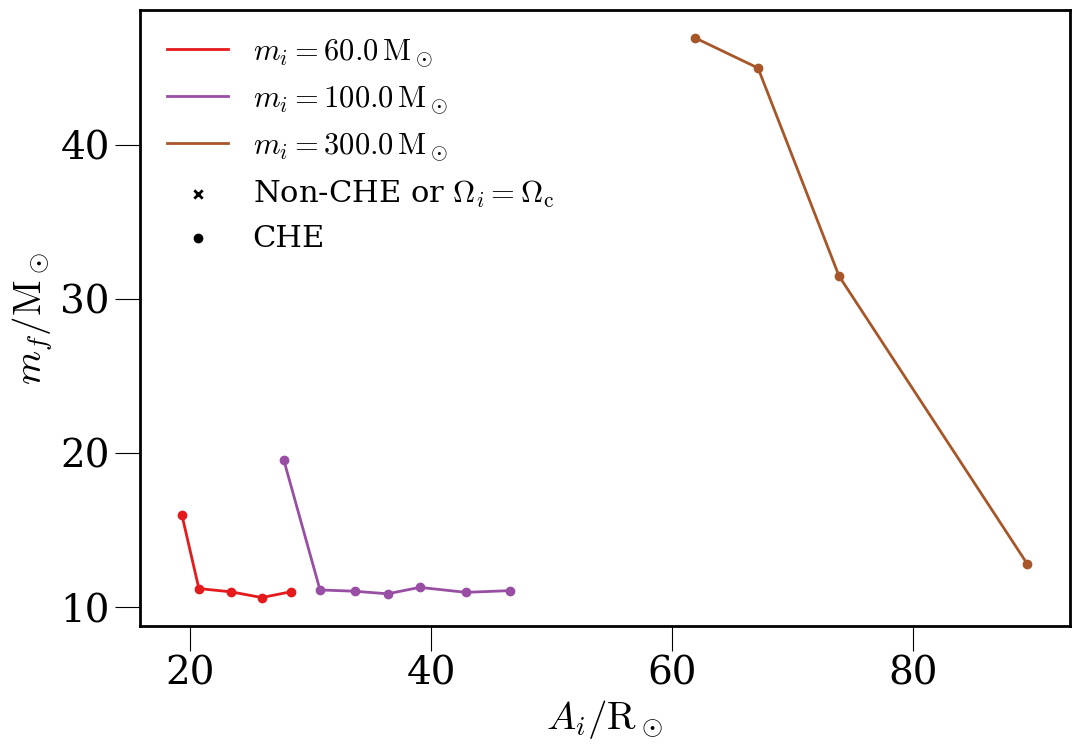

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    #plotarr = plotarr0
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, 4], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$m_f/\\mathrm{M}_\\odot$')

#ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(handles=handles, frameon=False, ncol=1)

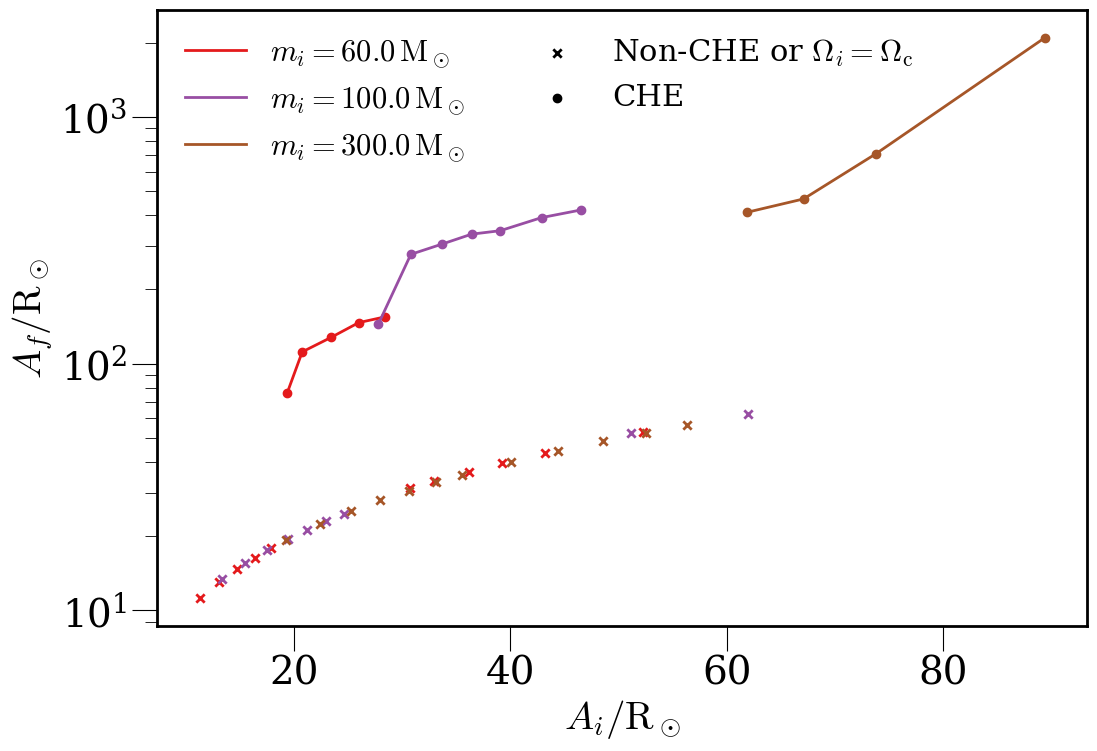

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, 6], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    plotarr = plotarr0[plotarr0[:, -1] != 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$A_f/\\mathrm{R}_\\odot$')

ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(handles=handles, frameon=False, ncol=2)

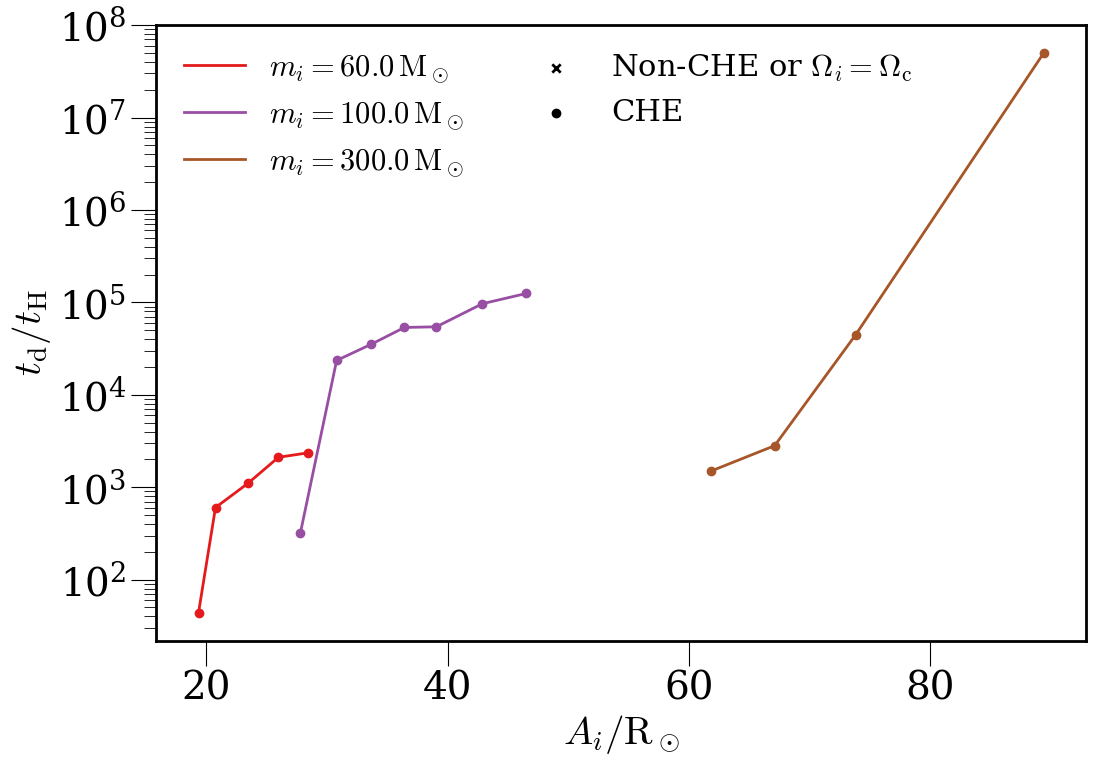

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, -3]/th, c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, -2]/th, color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, -3]/th, color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$t_\mathrm{d}/t_\mathrm{H}$')

ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(handles=handles, frameon=False, ncol=2)

No mergers at close to solar???

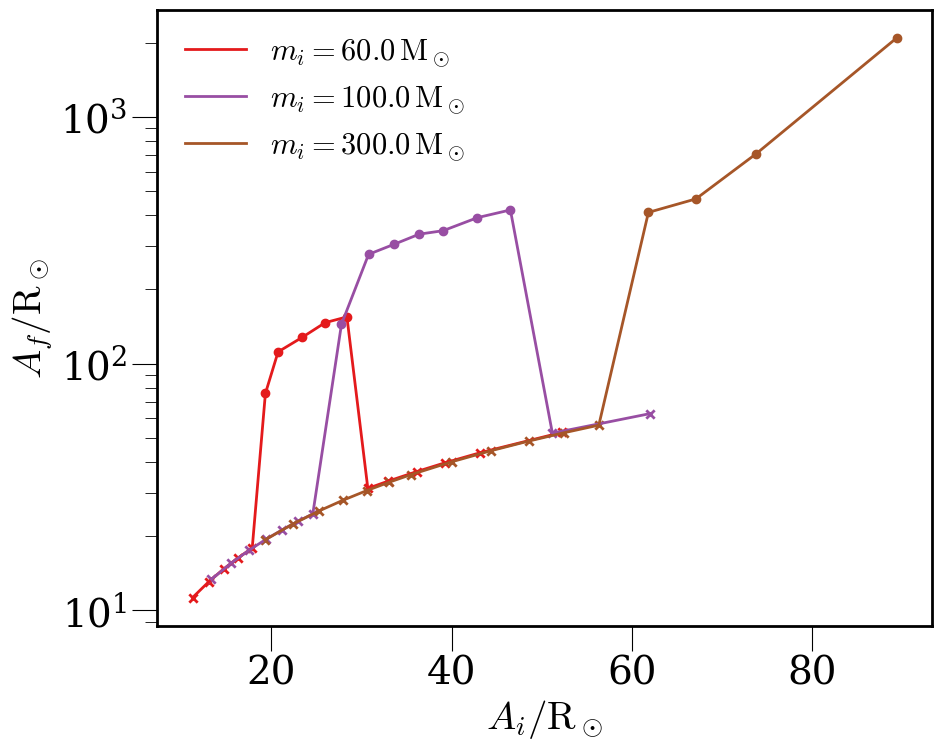

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0
    ax.plot(plotarr[:, 2], plotarr[:, 6], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    plotarr = plotarr0[plotarr0[:, -1] != 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$A_f/\\mathrm{R}_\\odot$')

ax.set_yscale('log')
ax.legend(frameon=False)

## Over metallicity

In [ ]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_01zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_02zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_04zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_06zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_08zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_1d0'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_10zsun = model_dicts

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZs

AttributeError: 'NoneType' object has no attribute 'glob'

In [ ]:
def get_mps_arr(model_dicts_base):
    model_dicts = dict()
    for dict_ in model_dicts_base:
        key = list(dict_.keys())[0]
        model_dicts[key] = dict_[key]

    m_keys = np.array(list(model_dicts.keys()))
    mi_arr = np.float32(m_keys)
    m_keys = m_keys[np.argsort(mi_arr)]
    mi_arr = np.sort(mi_arr)
    
    p_keys = np.array(list(model_dicts[m_keys[0]].keys()))

    mps_i_f_arr = np.zeros((len(m_keys)*len(p_keys),11))

    i = 0
    for m_key in m_keys:
        mi = float(m_key)
        dict_ = model_dicts[m_key]
        
        p_keys = np.array(list(dict_.keys()))
        pi_arr = np.float32(p_keys)
        p_keys = p_keys[np.argsort(pi_arr)]
        pi_arr = np.sort(pi_arr)
        for p_key in p_keys:
            pi = float(p_key)
            qi = 1.0
            ai = a_from_p(pi, mi, qi).to(u.Rsun).value
            
            model_path = dict_[p_key]
            try:
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                stop = 0
                print(f'Stop {stop} for {mi, pi, ai}')
                mf = mi
                pf = pi
                af = ai
                qf = qi
                tf = 1e11
            else:
                w_div_wc = h.surf_avg_omega_div_omega_crit
                w_div_wc = w_div_wc[w_div_wc > 0]
                if len(w_div_wc) == 0:
                    w_div_wc = [2]
                if w_div_wc[0] >= 1:
                    stop = 0
                    print(f'Stop {stop} for {mi, pi, ai}')
                    mf = mi
                    pf = pi
                    af = ai
                    qf = qi
                    tf = 1e11
                else:
                    x_cntr = h.center_h1
                    if x_cntr[-1] > 1e-6:
                        stop = 1
                        print(f'Stop {stop} for {mi, pi, ai}')
                    else:
                        stop = 2
                        print(f'Stop {stop} for {mi, pi, ai}')
                    
                    integrator = WindIntegrator(model_path)
                    mf, pf, af, qf, tf = integrator.integrate(1e9)
            finally:
                print(f'Run {i} from {mi,pi,ai,qi} to {mf, pf, af, qf}')
                tc = coalescence_time(mf, af, qf)
                td = tf + tc
                mps_i_f_arr[i] = [mi, pi, ai, qi, mf, pf, af, qf, tc, td, stop]
                i += 1
                print('')
    
    return mps_i_f_arr

In [ ]:
mps_arr_dict = dict()

In [ ]:
model_name = '01zsun'

arr_file = FIGURE_FOLDER/f'mps_i_f_arr_{model_name}.npy'
arr_name = f'mps_i_f_arr_{model_name}'
exec(f'dict_name = model_dicts_{model_name}')

if arr_file.exists():
    print(f'File {arr_file} found, loading into array {arr_name}')
    mps_arr_dict[arr_name] = np.load(arr_file)
else:
    print(f'File {arr_file} not found, generating array {arr_name}')
    
    arr = get_mps_arr(dict_name)
    mps_arr_dict[arr_name] = arr
    print(f'Saving to {arr_file}')
    np.save(arr_file, arr)
    

File output/nb35/figures/mps_i_f_arr_01zsun.npy found, loading into array mps_i_f_arr_01zsun


In [ ]:
model_name = '02zsun'

arr_file = FIGURE_FOLDER/f'mps_i_f_arr_{model_name}.npy'
arr_name = f'mps_i_f_arr_{model_name}'
dict_name = model_dicts_08zsun

if arr_file.exists():
    print(f'File {arr_file} found, loading into array {arr_name}')
    mps_arr_dict[arr_name] = np.load(arr_file)
else:
    print(f'File {arr_file} not found, generating array {arr_name}')
    
    arr = get_mps_arr(dict_name)
    mps_arr_dict[arr_name] = arr
    print(f'Saving to {arr_file}')
    np.save(arr_file, arr)
    

File output/nb35/figures/mps_i_f_arr_02zsun.npy found, loading into array mps_i_f_arr_02zsun


In [ ]:
model_name = '08zsun'

arr_file = FIGURE_FOLDER/f'mps_i_f_arr_{model_name}.npy'
arr_name = f'mps_i_f_arr_{model_name}'
dict_name = model_dicts_08zsun

if arr_file.exists():
    print(f'File {arr_file} found, loading into array {arr_name}')
    mps_arr_dict[arr_name] = np.load(arr_file)
else:
    print(f'File {arr_file} not found, generating array {arr_name}')
    
    arr = get_mps_arr(dict_name)
    mps_arr_dict[arr_name] = arr
    print(f'Saving to {arr_file}')
    np.save(arr_file, arr)
    

File output/nb35/figures/mps_i_f_arr_08zsun.npy found, loading into array mps_i_f_arr_08zsun


In [ ]:
mps_arr_dict.keys()

dict_keys(['mps_i_f_arr_01zsun', 'mps_i_f_arr_02zsun', 'mps_i_f_arr_08zsun'])

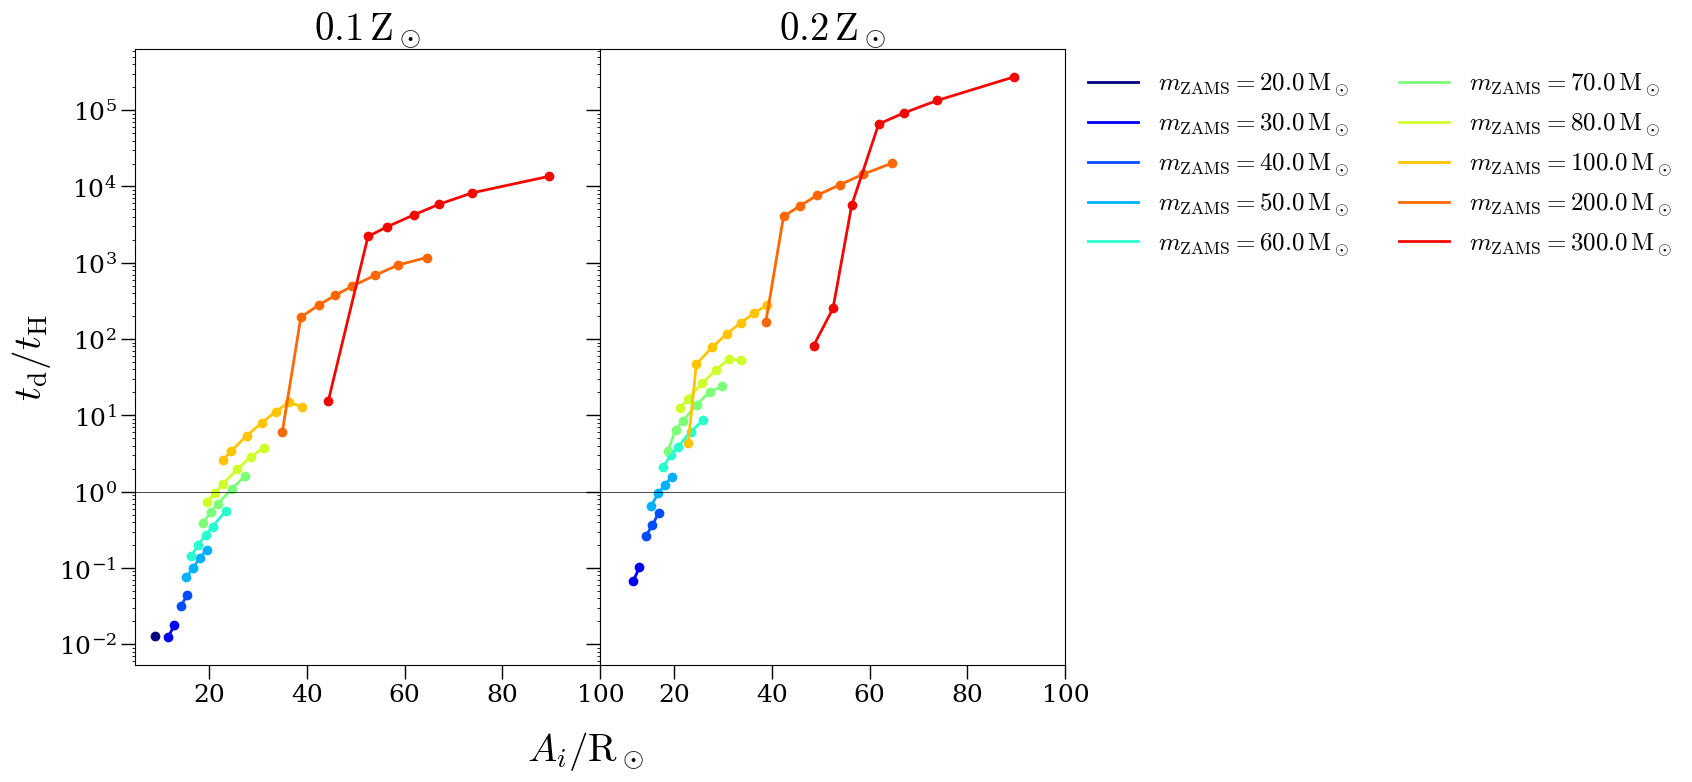

In [ ]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
fig.subplots_adjust(wspace=0)

mps_i_f_arr1 = mps_arr_dict['mps_i_f_arr_01zsun']
mps_i_f_arr2 = mps_arr_dict['mps_i_f_arr_02zsun']

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.jet

ax = ax0
mps_i_f_arr = mps_i_f_arr1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, -3]/th, c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, -2]/th, color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, -3]/th, color=c, marker='o')

ax.set_yscale('log')

ax = ax1
mps_i_f_arr = mps_i_f_arr2


for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, -3]/th, c=c, label=f'$m_\mathrm{{ZAMS}}={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, -2]/th, color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, -3]/th, color=c, marker='o')
    
fig.text(0.5, 0.03, '$A_i/\\mathrm{R}_\\odot$', ha='center', va='top')
ax0.set_ylabel('$t_\mathrm{d}/t_\mathrm{H}$')

ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(1,1), fontsize=18)

ax0.set_title('$0.1\\,\\mathrm{Z}_\\odot$')
ax1.set_title('$0.2\\,\\mathrm{Z}_\\odot$')

ax0.set_xlim(5, 100)
ax0.hlines(1, 0, 120, color='k', linestyle='-', linewidth=0.5)
ax1.set_xlim(5, 100)
ax1.hlines(1, 0, 120, color='k', linestyle='-', linewidth=0.5)

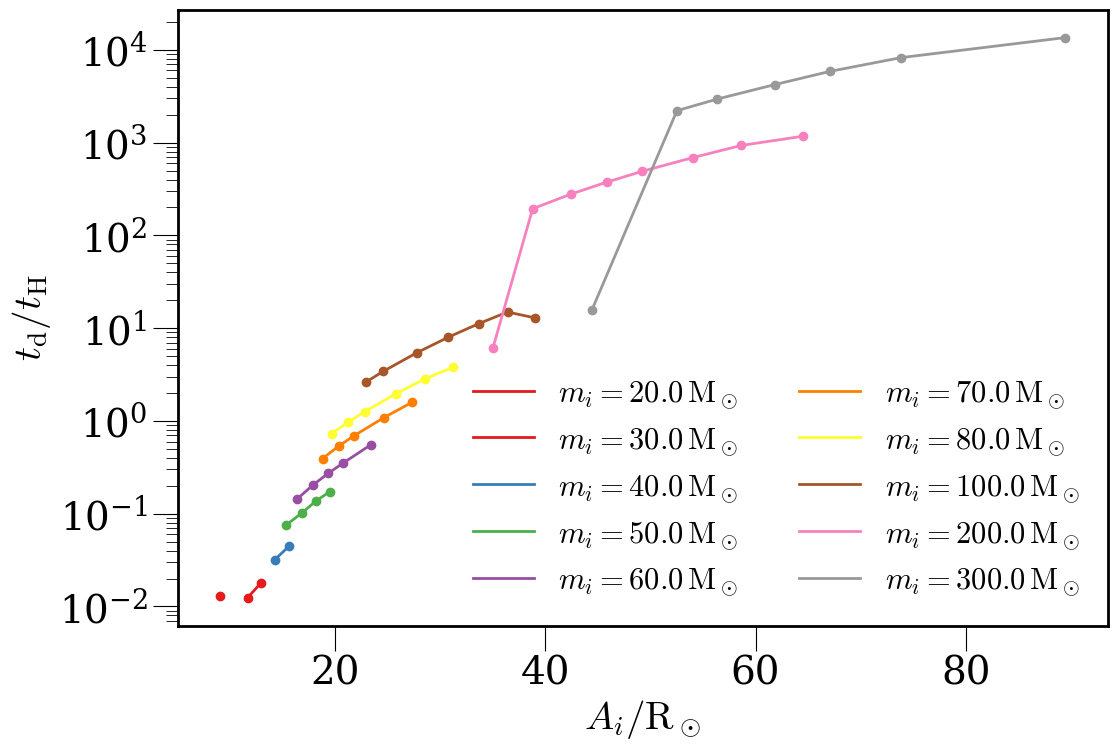

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_i_f_arr = mps_arr_dict['mps_i_f_arr_01zsun']

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, -3]/th, c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, -2]/th, color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, -3]/th, color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$t_\mathrm{d}/t_\mathrm{H}$')

ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(frameon=False, ncol=2)

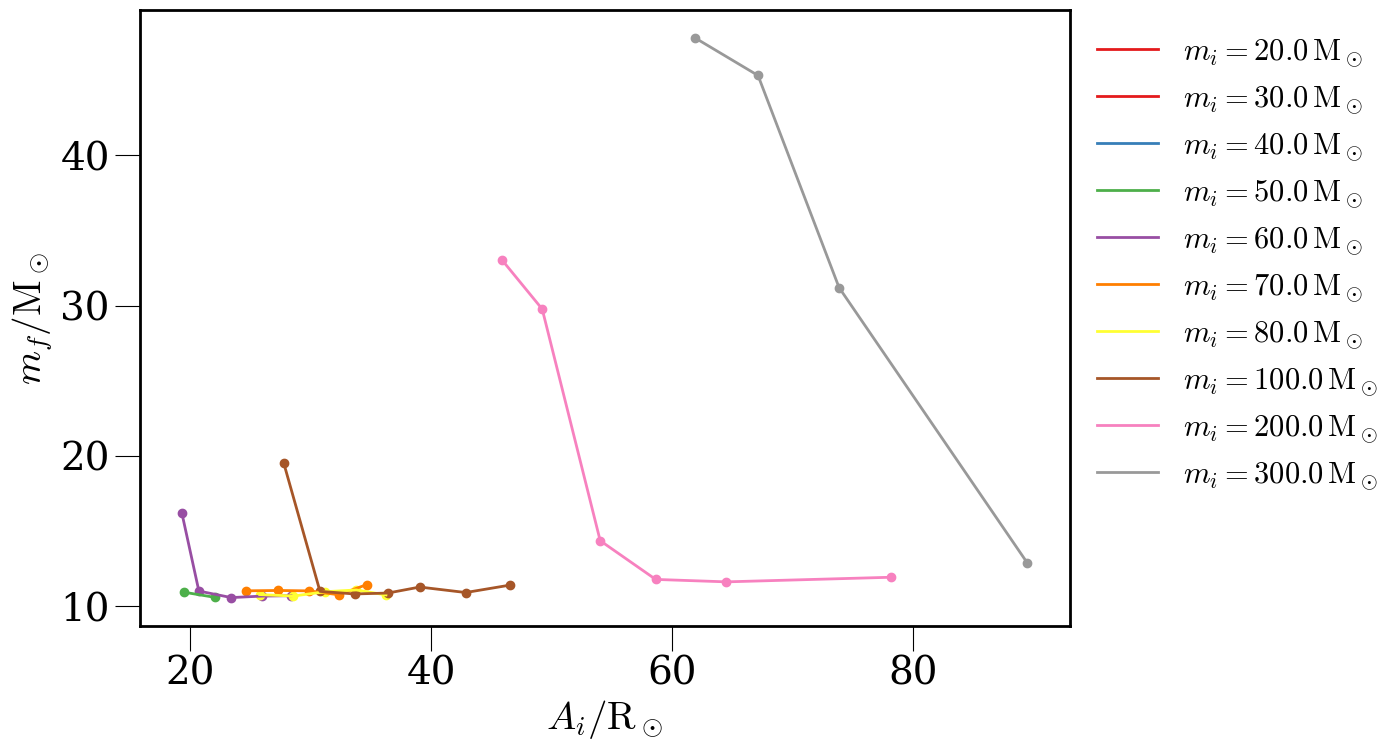

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    #plotarr = plotarr0
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, 4], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$m_f/\\mathrm{M}_\\odot$')

#ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(1, 1))

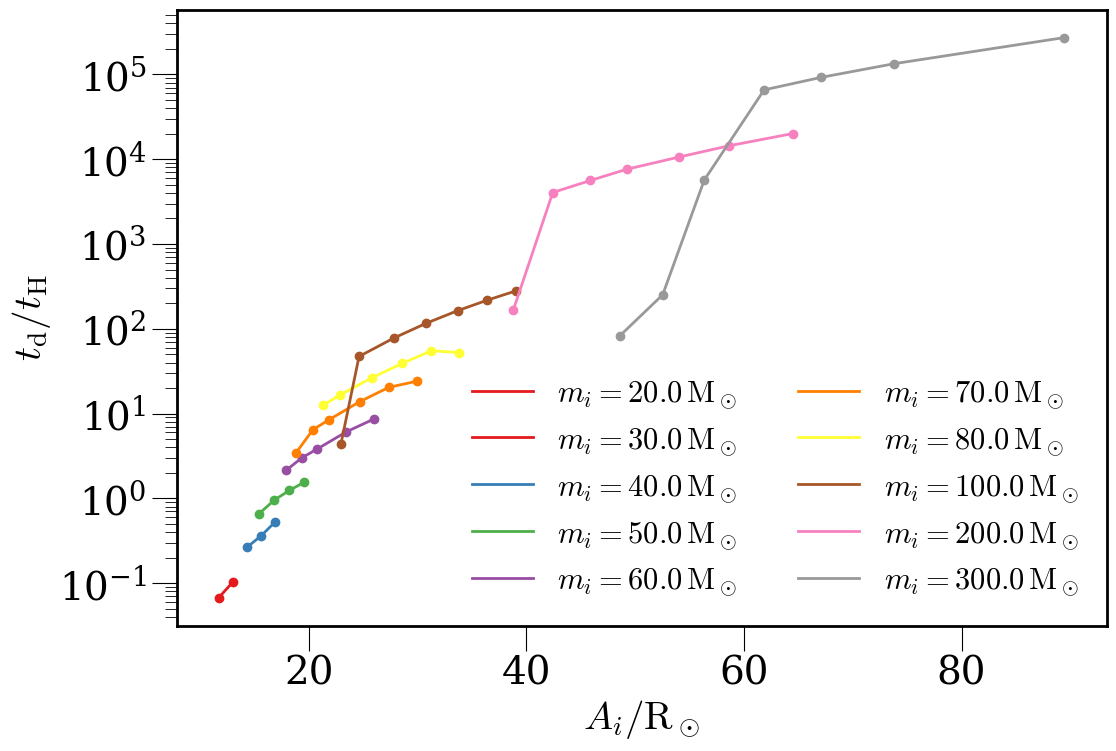

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_i_f_arr = mps_arr_dict['mps_i_f_arr_02zsun']

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, -3]/th, c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, -2]/th, color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, -3]/th, color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$t_\mathrm{d}/t_\mathrm{H}$')

ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(frameon=False, ncol=2)

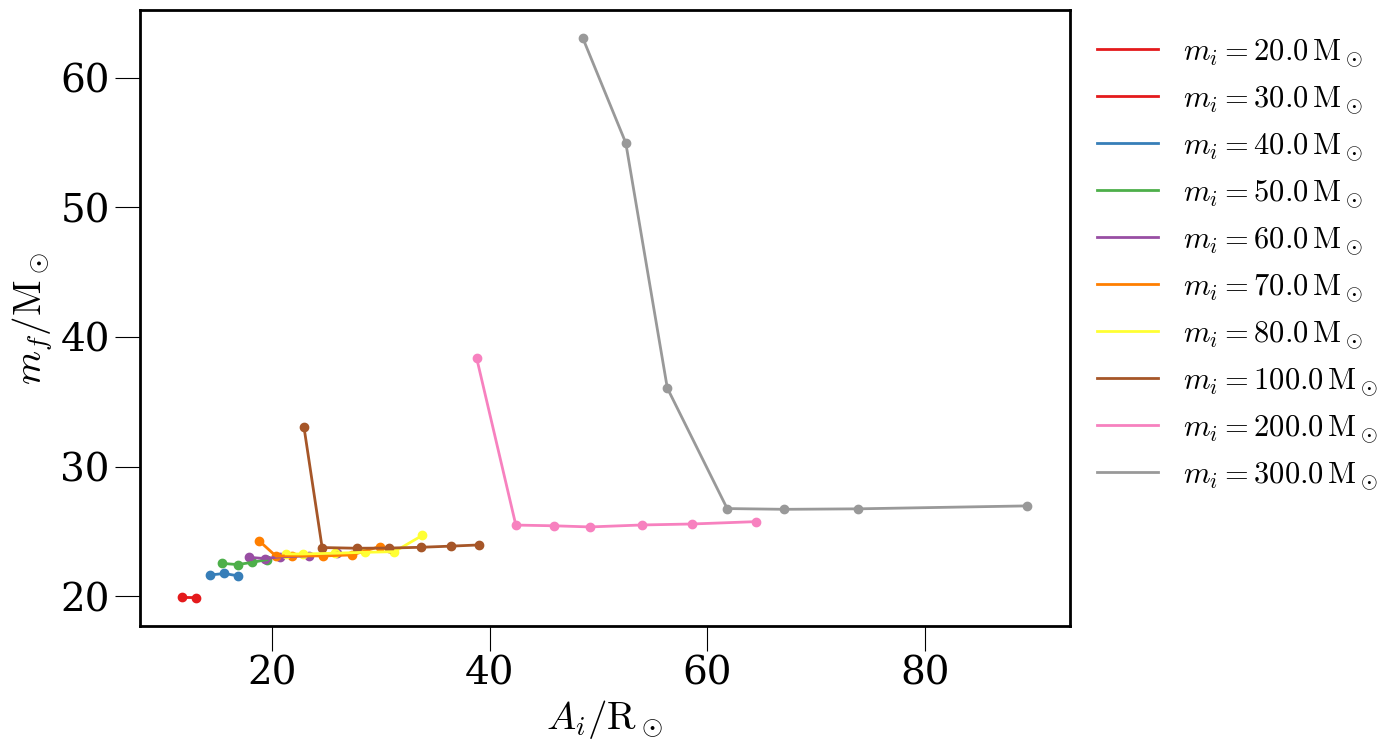

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    #plotarr = plotarr0
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, 4], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    #plotarr = plotarr0[plotarr0[:, -1] != 2]
    #ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 4], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$m_f/\\mathrm{M}_\\odot$')

#ax.set_yscale('log')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
#handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(1, 1))

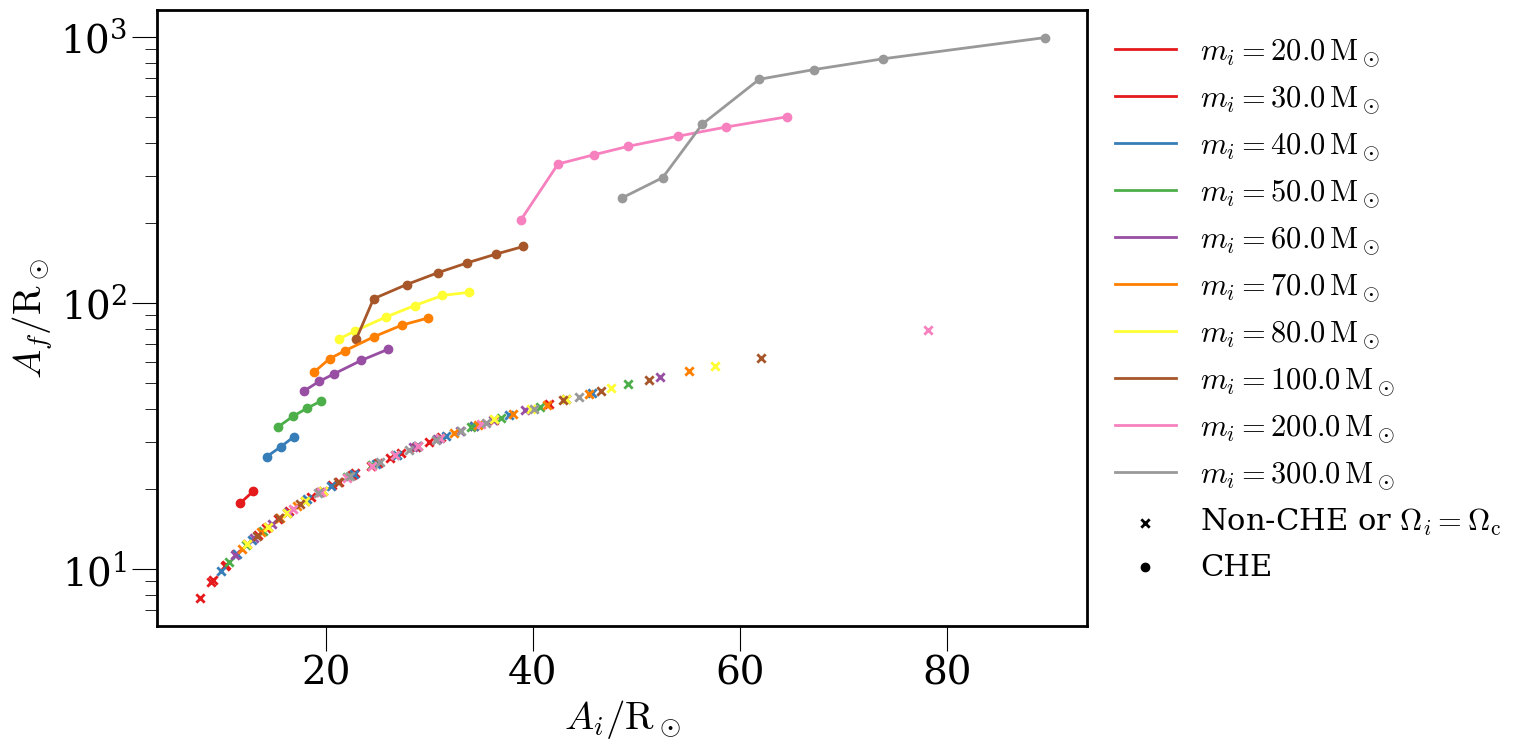

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

mps_arr_masses = np.sort(np.unique(mps_i_f_arr[:, 0]))
cmap = cm.Set1

for i, m in enumerate(mps_arr_masses):
    c = cmap(i/len(mps_arr_masses))
    plotarr0 = mps_i_f_arr[mps_i_f_arr[:, 0] == m]
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.plot(plotarr[:, 2], plotarr[:, 6], c=c, label=f'$m_i={m}\\,\\mathrm{{M}}_\\odot$')
    
    plotarr = plotarr0[plotarr0[:, -1] != 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='x')
    
    plotarr = plotarr0[plotarr0[:, -1] == 2]
    ax.scatter(plotarr[:, 2], plotarr[:, 6], color=c, marker='o')
    
ax.set_xlabel('$A_i/\\mathrm{R}_\\odot$')
ax.set_ylabel('$A_f/\\mathrm{R}_\\odot$')

ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], marker='x', color='k', label='Non-CHE or $\\Omega_i=\\Omega_\\mathrm{c}$'))
handles.append(ax.scatter([], [], marker='o', color='k', label='CHE'))
ax.legend(handles=handles, frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(1, 1))

Why do masses pile up around the same final value irrespective of the initial mass?

In [ ]:
def plot_history(model_path, x, y, ax, label=None):
    h = mr.MesaData(str(model_path/'LOGS/history.data'))
    xdata = eval(mesareader_operator(x))
    ydata = eval(mesareader_operator(y))
    if label is None:
        ax.plot(xdata, ydata)
    else:
        ax.plot(xdata, ydata, label=label)
    return ax

In [ ]:
def scatter_history(model_path, x, y, c, cmap, ax, label=None, s=10):
    h = mr.MesaData(str(model_path/'LOGS/history.data'))
    xdata = eval(mesareader_operator(x))
    ydata = eval(mesareader_operator(y))
    cdata = eval(mesareader_operator(c))
    cdata = cmap(
        (cdata-min(cdata))/(max(cdata)-min(cdata))
        )
    if label is None:
        ax.scatter(xdata, ydata, c=cdata, s=s)
    else:
        ax.scatter(xdata, ydata, c=cdata, label=label, s=s)
    return ax

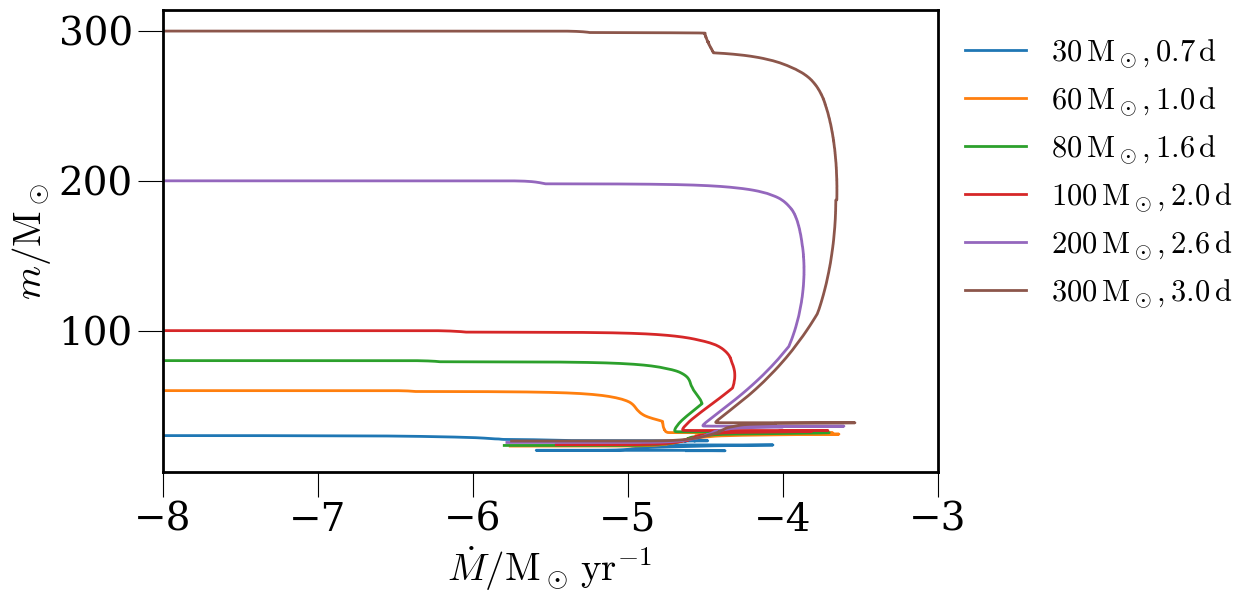

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'

fig, ax = plt.subplots(figsize=(10, 6))

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = plot_history(model_dicts['30.0']['0.70'], x, y, ax, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

ax.set_xlim(-8, -3)
ax.set_ylabel('$m/\\mathrm{M}_\\odot$')
ax.set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

In [ ]:
def he_surf_normalizer(y):
    if y < 0.4:
        print('1', y, 0)
        return 0
    elif y < 0.7:
        print('2', y, (y-0.4)/0.3)
        return (y-0.4)/0.3
    else:
        print('3', y, 1)
        return 1
he_surf_normalizer = np.vectorize(he_surf_normalizer, otypes=[float])

In [ ]:
def he_surf_cmap(c):
    return cm.viridis(he_surf_normalizer(c))

In [ ]:
np.linspace(0, 1, 10), he_surf_normalizer(np.linspace(0, 1, 10)), he_surf_cmap(np.linspace(0, 1, 10))

1 0.0 0
1 0.1111111111111111 0
1 0.2222222222222222 0
1 0.3333333333333333 0
2 0.4444444444444444 0.148148148148148
2 0.5555555555555556 0.5185185185185186
2 0.6666666666666666 0.8888888888888887
3 0.7777777777777777 1
3 0.8888888888888888 1
3 1.0 1
1 0.0 0
1 0.1111111111111111 0
1 0.2222222222222222 0
1 0.3333333333333333 0
2 0.4444444444444444 0.148148148148148
2 0.5555555555555556 0.5185185185185186
2 0.6666666666666666 0.8888888888888887
3 0.7777777777777777 1
3 0.8888888888888888 1
3 1.0 1


(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.14814815,
        0.51851852, 0.88888889, 1.        , 1.        , 1.        ]),
 array([[0.267004, 0.004874, 0.329415, 1.      ],
        [0.267004, 0.004874, 0.329415, 1.      ],
        [0.267004, 0.004874, 0.329415, 1.      ],
        [0.267004, 0.004874, 0.329415, 1.      ],
        [0.274128, 0.199721, 0.498911, 1.      ],
        [0.123463, 0.581687, 0.547445, 1.      ],
        [0.709898, 0.868751, 0.169257, 1.      ],
        [0.993248, 0.906157, 0.143936, 1.      ],
        [0.993248, 0.906157, 0.143936, 1.      ],
        [0.993248, 0.906157, 0.143936, 1.      ]]))

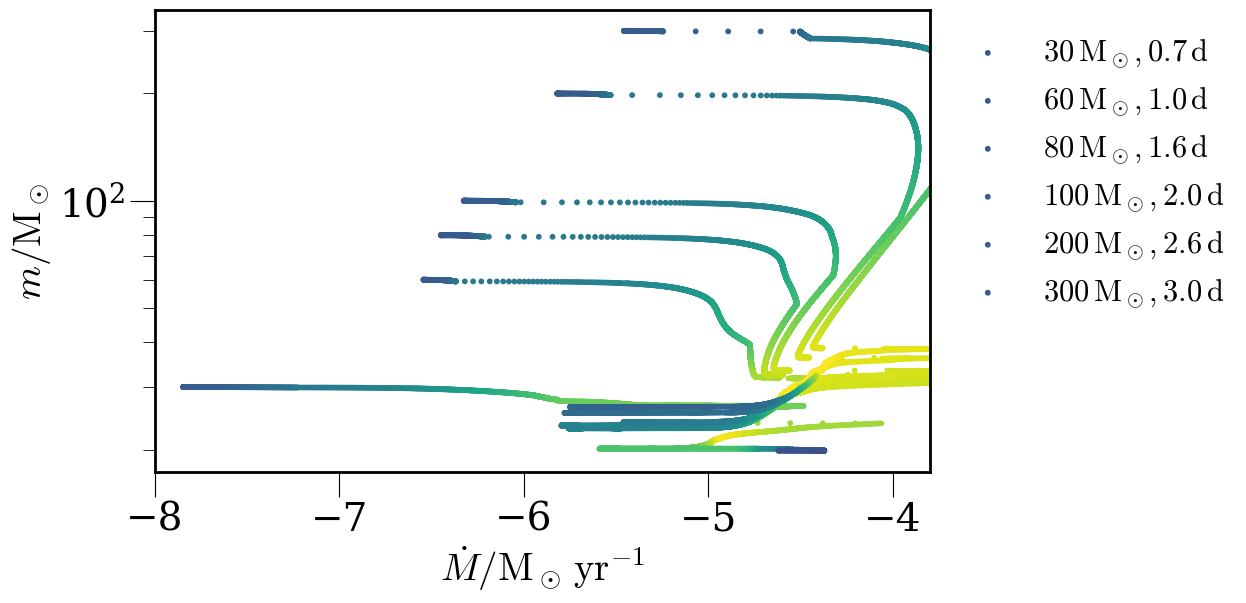

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'surface_he4'

fig, ax = plt.subplots(figsize=(10, 6))

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

ax.set_xlim(-8, -3.8)
ax.set_yscale('log')
ax.set_ylabel('$m/\\mathrm{M}_\\odot$')
ax.set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

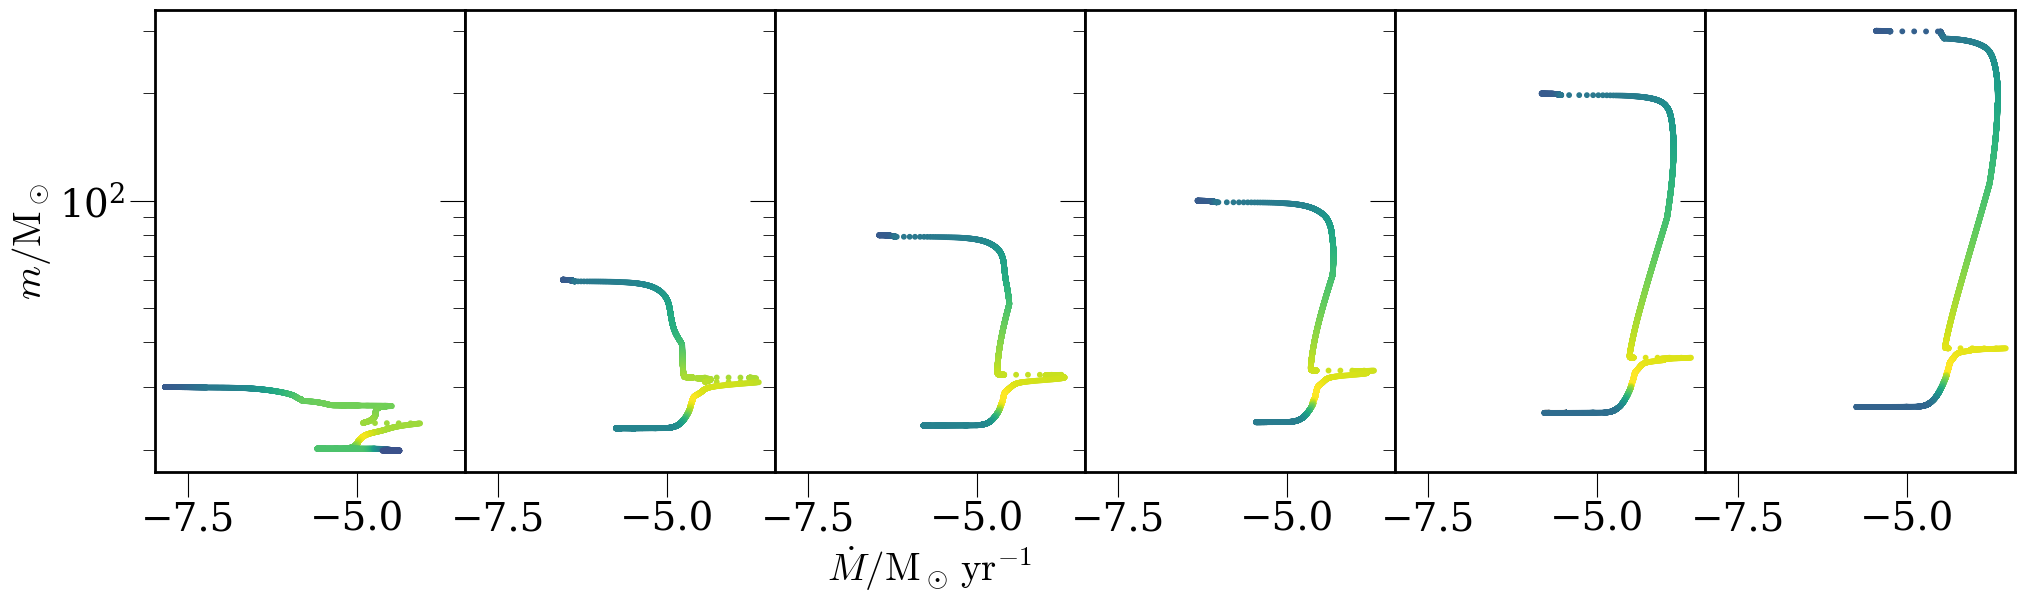

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'surface_he4'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

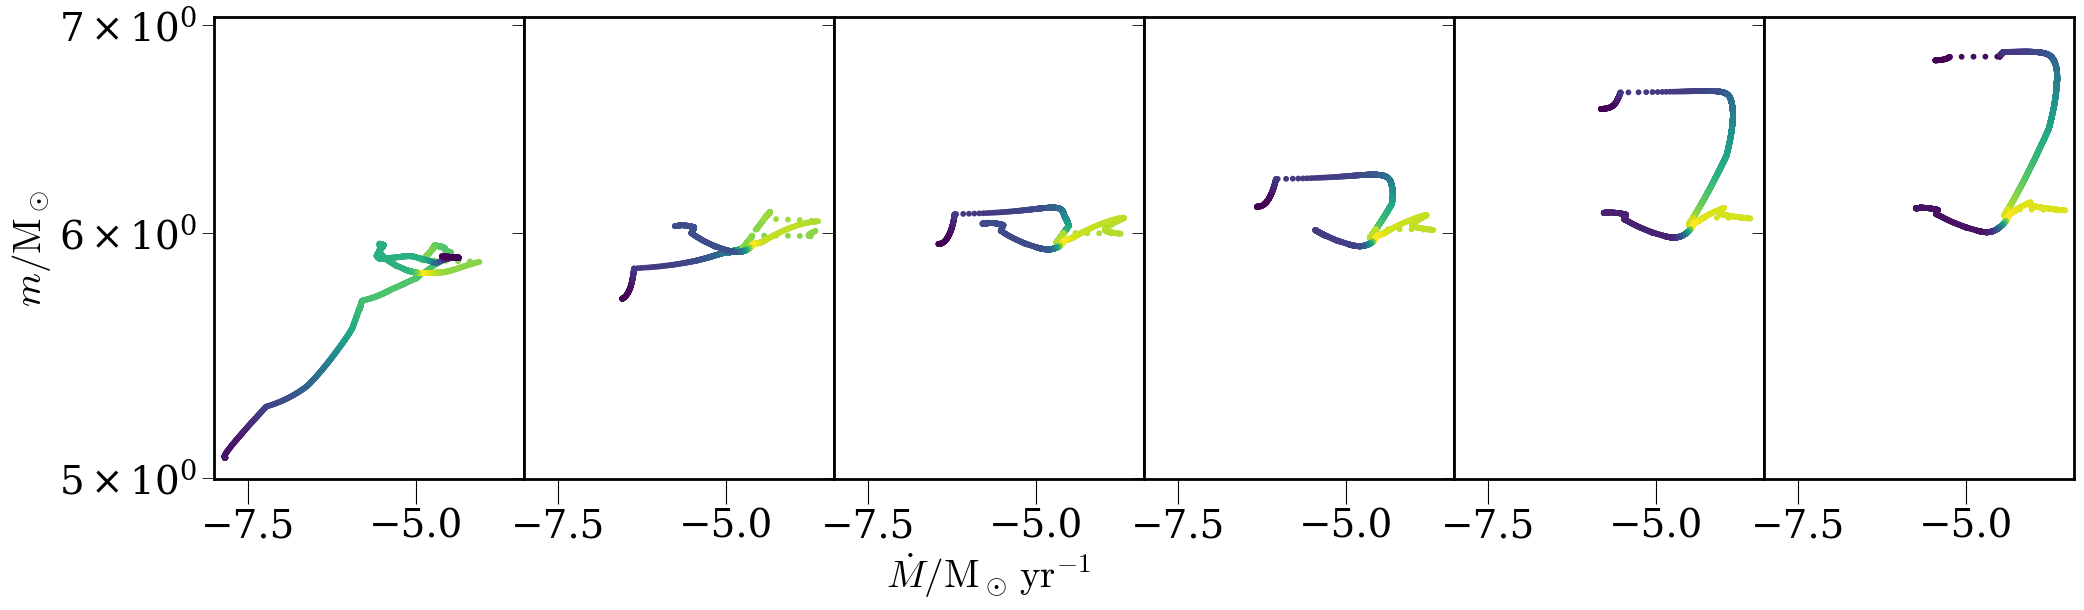

In [ ]:
x = 'log_abs_mdot'
y = 'log_L'
c = 'surface_he4'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
#axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

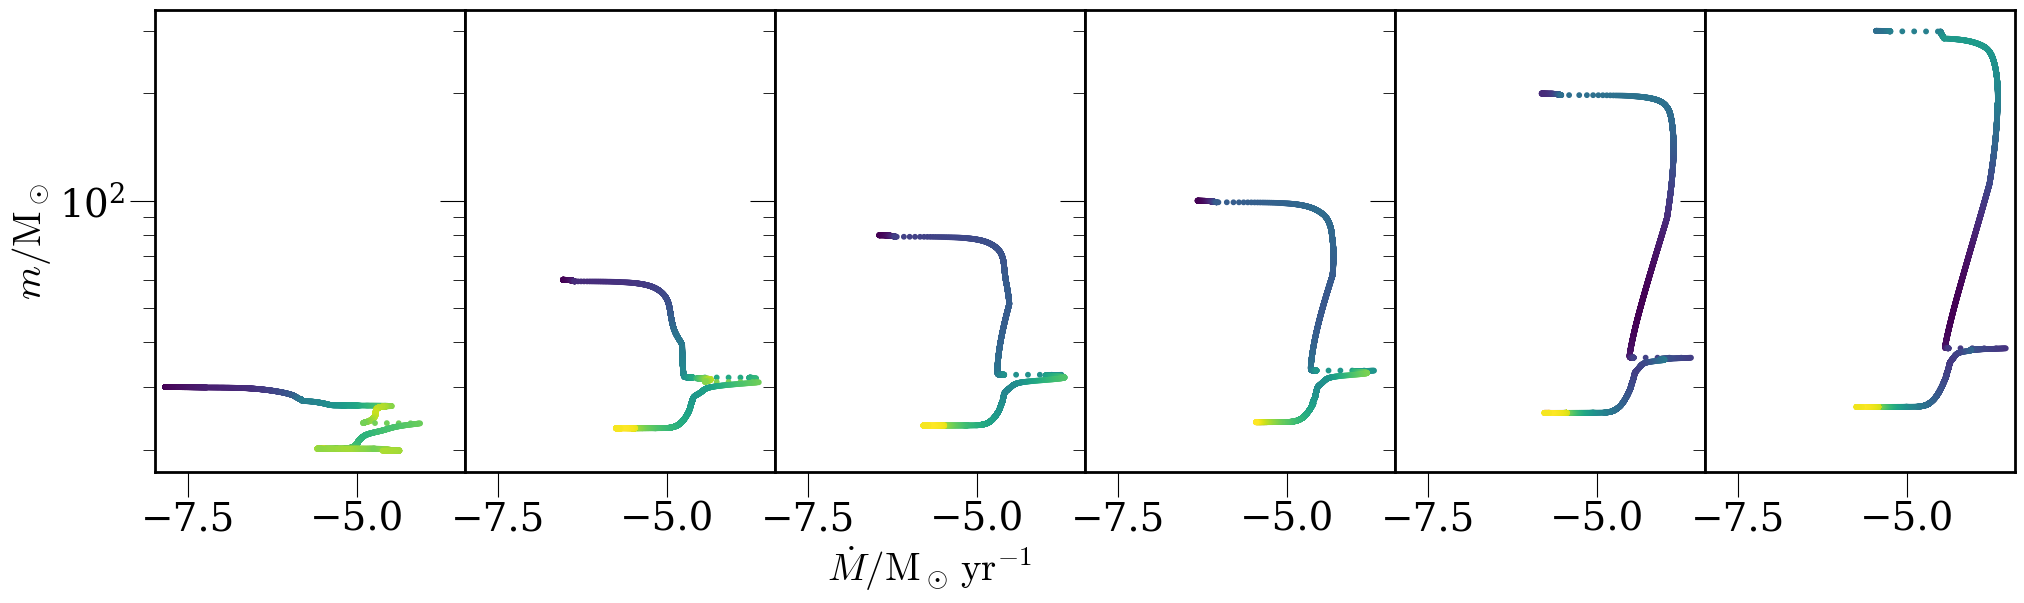

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'Estar_mass,^log_L,surface_h1)'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

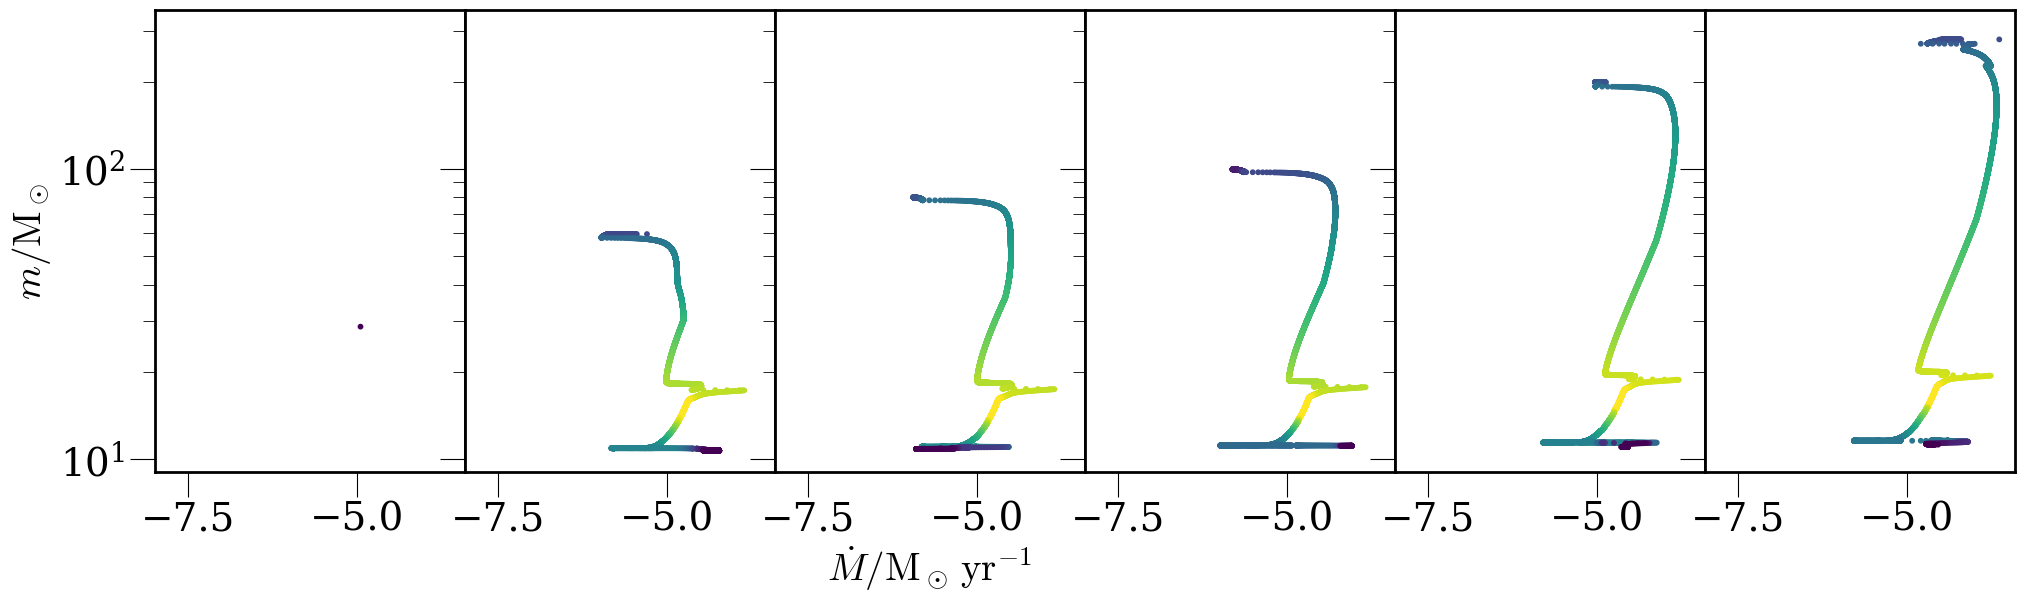

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'surface_he4'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_08zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

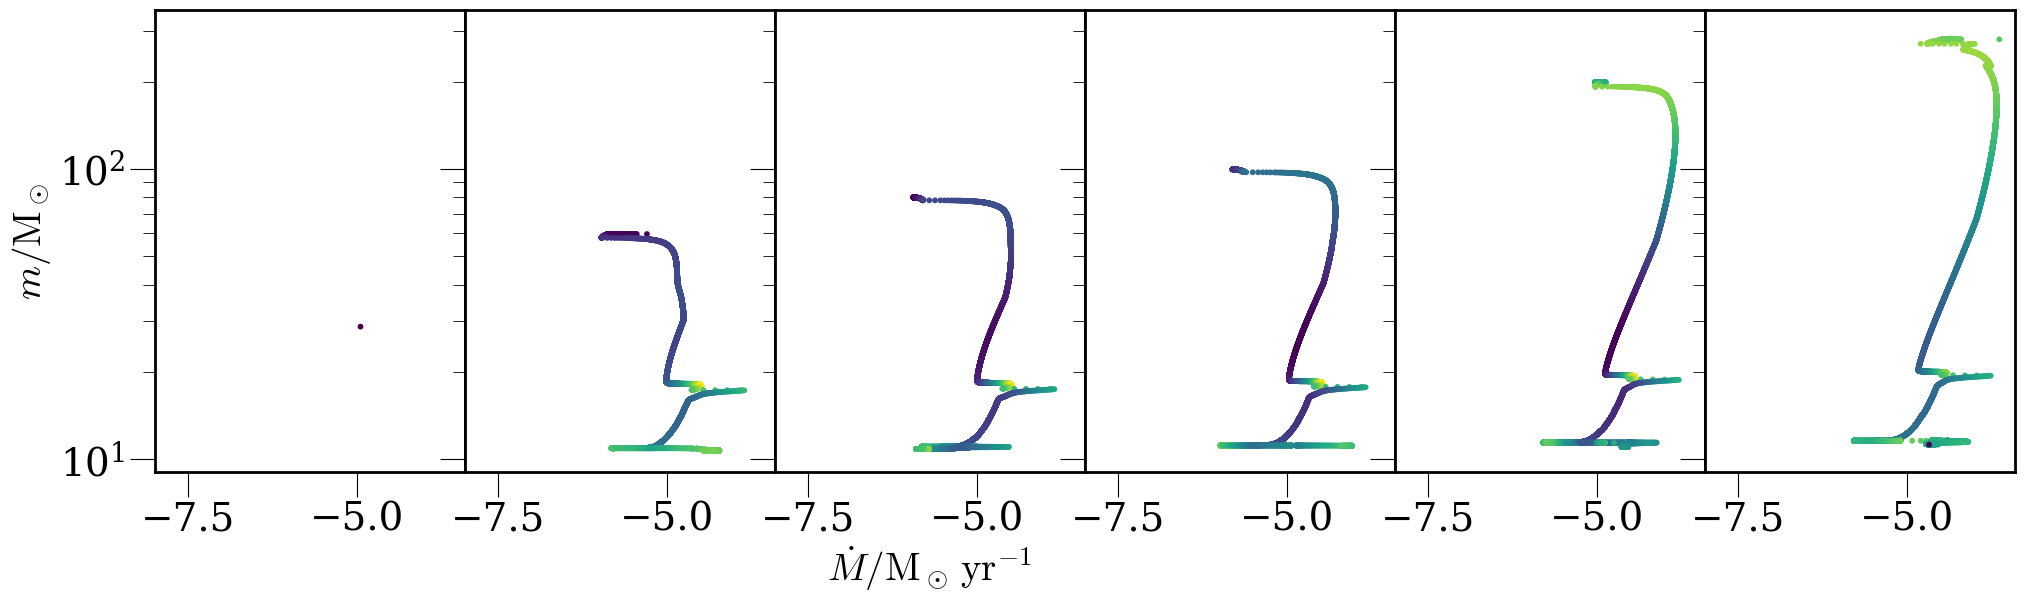

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'Estar_mass,^log_L,surface_h1)'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_08zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

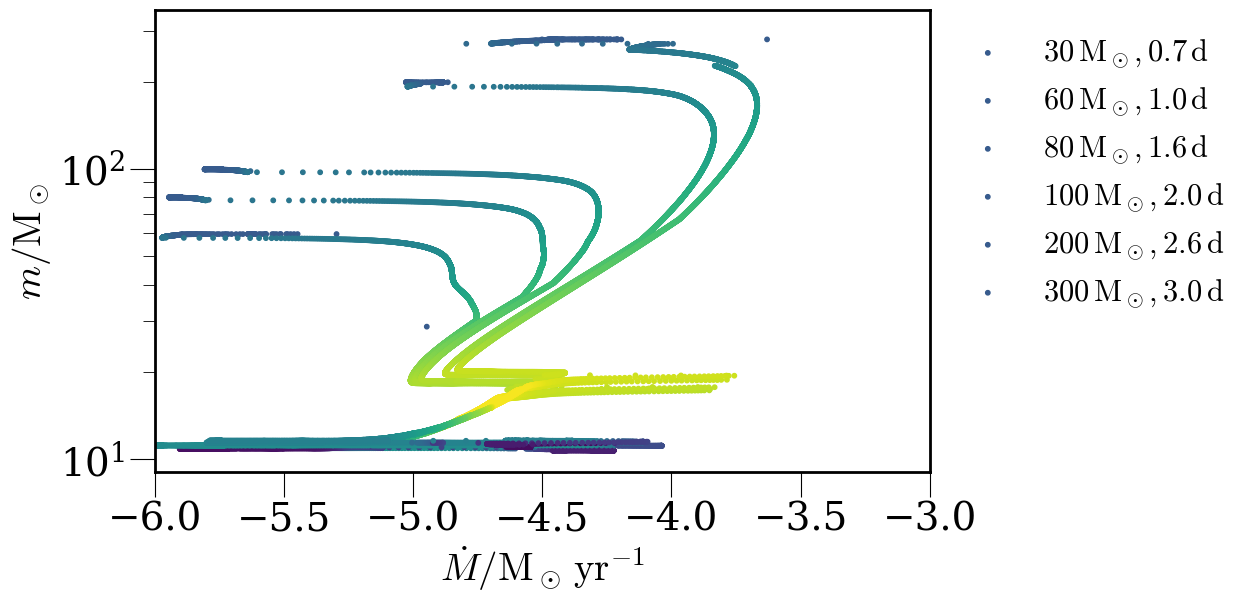

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'surface_he4'

fig, ax = plt.subplots(figsize=(10, 6))

model_dicts_base = model_dicts_08zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

ax.set_xlim(-6, -3)
ax.set_yscale('log')
ax.set_ylabel('$m/\\mathrm{M}_\\odot$')
ax.set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

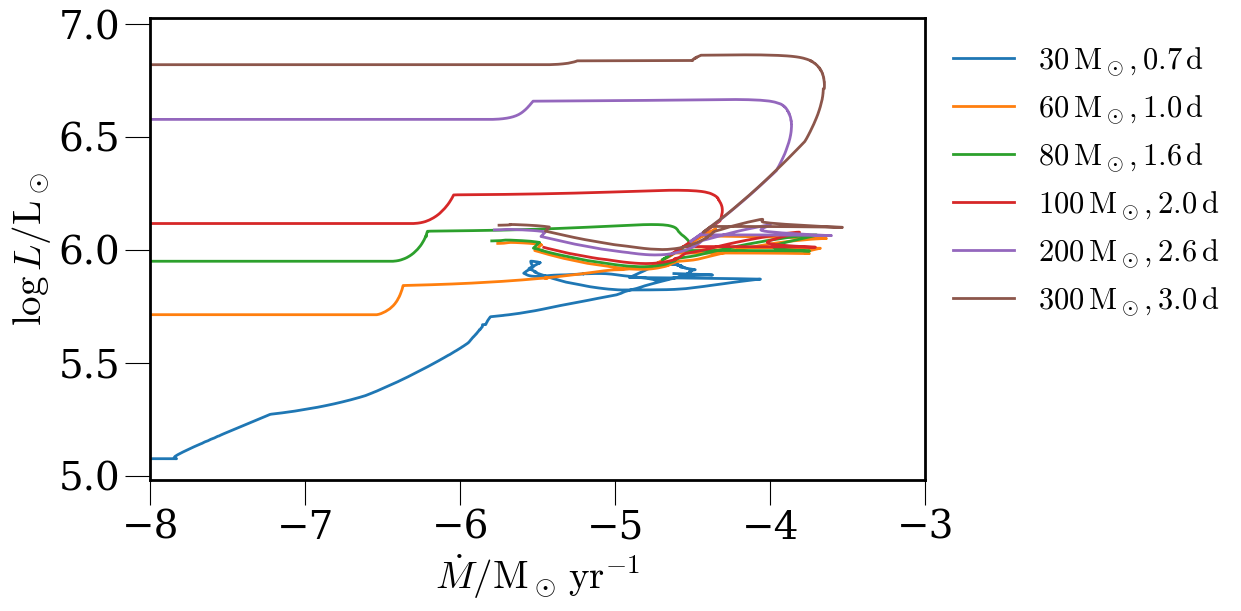

In [ ]:
x = 'star_mass'
y = 'log_L'

fig, ax = plt.subplots(figsize=(10, 6))

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = plot_history(model_dicts['30.0']['0.70'], x, y, ax, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax.set_xlim(-8, -3)
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_xlabel('$m/\\mathrm{M}_\\odot$')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

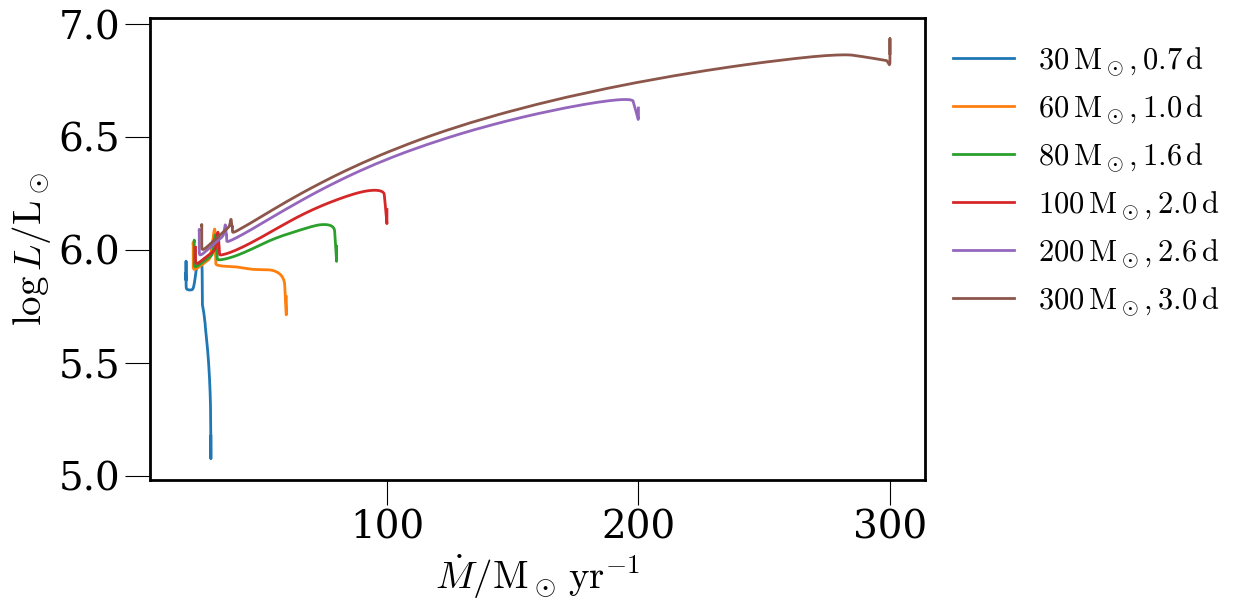

In [ ]:
x = 'star_mass'
y = 'log_L'

fig, ax = plt.subplots(figsize=(10, 6))

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = plot_history(model_dicts['30.0']['0.70'], x, y, ax, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax.set_xlim(-8, -3)
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

# Wind pileup

Text(0.5, 0, '$\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')

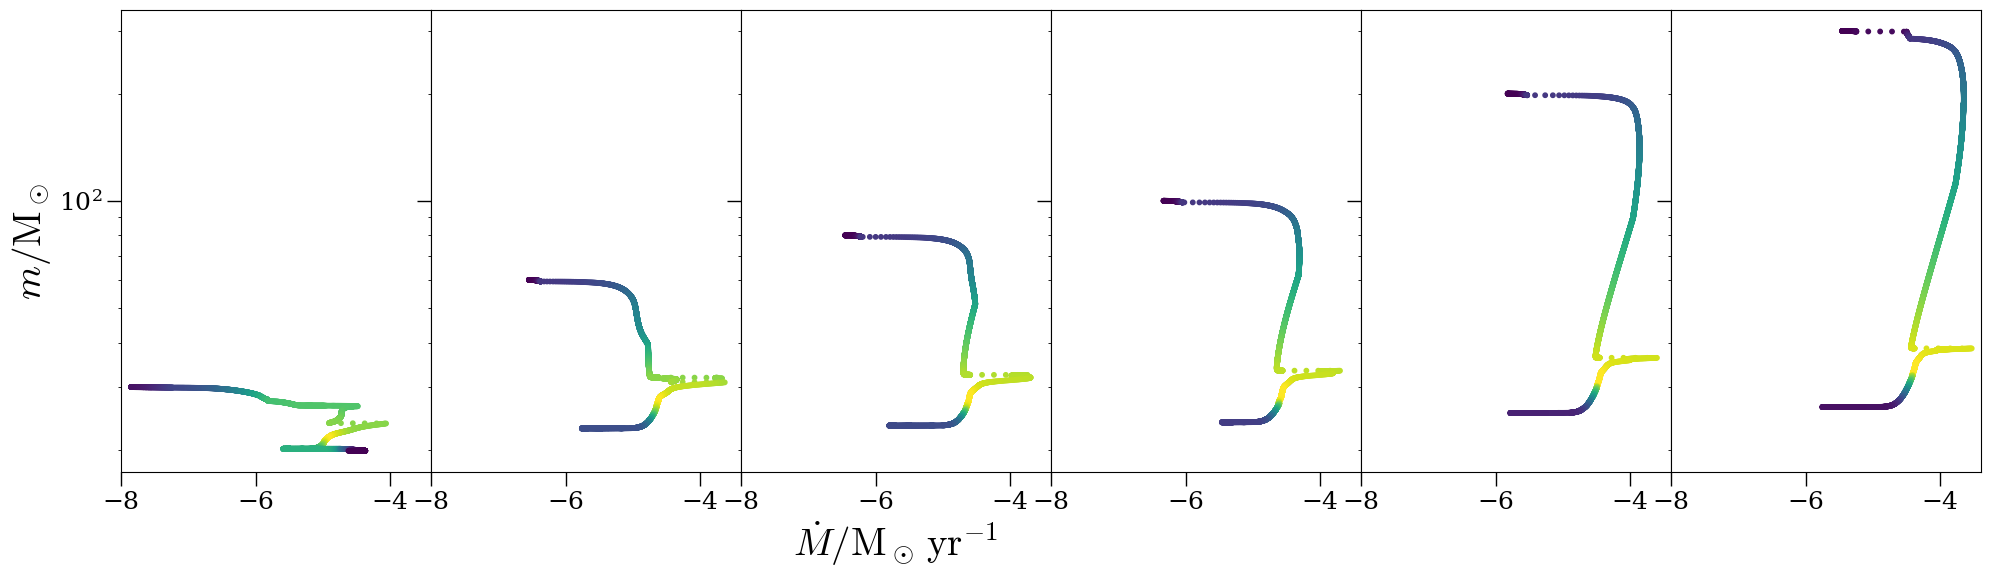

In [ ]:
x = 'log_abs_mdot'
y = 'star_mass'
c = 'surface_he4'

fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dicts_base = model_dicts_02zsun
model_dicts = dict()
for dict_ in model_dicts_base:
    key = list(dict_.keys())[0]
    model_dicts[key] = dict_[key]

ax = axes[0]
ax = scatter_history(model_dicts['30.0']['0.70'], x, y, c, cm.viridis, ax, s=10, label='$30\\,\\mathrm{M}_\\odot,0.7\\,\\mathrm{d}$')
ax = axes[1]
ax = scatter_history(model_dicts['60.0']['1.00'], x, y, c, cm.viridis, ax, s=10, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
ax = axes[2]
ax = scatter_history(model_dicts['80.0']['1.60'], x, y, c, cm.viridis, ax, s=10, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
ax = axes[3]
ax = scatter_history(model_dicts['100.0']['2.00'], x, y, c, cm.viridis, ax, s=10, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
ax = axes[4]
ax = scatter_history(model_dicts['200.0']['2.60'], x, y, c, cm.viridis, ax, s=10, label='$200\\,\\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
ax = axes[5]
ax = scatter_history(model_dicts['300.0']['3.00'], x, y, c, cm.viridis, ax, s=10, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

#ax = plot_history(model_dicts['60.0']['1.00'], x, y, ax, label='$60\\,\\mathrm{M}_\\odot,1.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['80.0']['1.60'], x, y, ax, label='$80\\,\\mathrm{M}_\\odot,1.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['100.0']['2.00'], x, y, ax, label='$100\\,\\mathrm{M}_\\odot,2.0\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['200.0']['2.60'], x, y, ax, label='$200\\,\a\mathrm{M}_\\odot,2.6\\,\\mathrm{d}$')
#ax = plot_history(model_dicts['300.0']['3.00'], x, y, ax, label='$300\\,\\mathrm{M}_\\odot,3.0\\,\\mathrm{d}$')

axes[0].set_xlim(-8, -3.4)
axes[0].set_yscale('log')
axes[0].set_ylabel('$m/\\mathrm{M}_\\odot$')
axes[2].set_xlabel('$\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$')
#ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')